# Modal Analysis, MAC and Model Correction or Updating of the FE models using Test Data
#### By Sainag Immidisetty






## Required Modules:

In [120]:
%load_ext autoreload
%autoreload 2
import pylab
import mpld3
import control as ctrl
import vibrationtesting as vt
from vibrationtesting import sos_modal
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
import numpy as np
import scipy.io as sio
import array_to_latex as a2t
from scipy.sparse import *
from OpenModal import *
import OpenModal as om
#from OpenModal.analysis.utility_functions import prime_factors
import OpenModal.analysis as ana
#from PyFRF.fft_tools impro
from pyFRF import FRF
import vibration_toolbox as vib
np.set_printoptions(precision = 9, linewidth = 220, suppress = True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
import scipy as sp

## Purpose of bridging the gap between Testing and FE-Simulation:


**Product Development Process:** There are five phases in this process along the cost curve.

- Top two phases: **Concept and Detail Drawing**, in these phases, the CAD and FEA simulation play the major role. So, any change of product design is very inexpensive and it doesn't take much time for modifications.


- Next two phases: **Prototype and Production**: in these phases, it becomes little bit more expensive to change the aspects of the product design. So, it gets more expensive as we move forward.


- Final phase: **Field Failure (Testing)**, this is the phase where product recalls occur to make a major design change and it gets much more expensive.


To avoid this sort of serious field failure, it is important to combine the testing and the simulation so that validating not only the physical design but also whether the FE simulation is correct. So, the first preference is given to validation at the test condition to use the right modeling technique in simulation to look at the variations and develop the model a head of time to see certain phenomenon that would replicate the real world.

## Purpose of doing Modal Analysis:

Modal Analysis is basically the process of identifying the dynamic behavior of a system (structure) in terms of it's modal parameters such as Natural Frequency, Damping and Mode shape.


The most important reasons for obtaining these modal parameters of any structure is to understand:


- **Durability**


- **how to minimize vibration of the structure**


- **Making sure that the driving frequencies don't overlay with natural frequencies**

## The Structure used for this project:



Ideally, testing has to be done under free-free condition, which means mounting the structure to a spring or bungee cord that has very low resonance frequency. However, here, as the first resonance is quite high so clamping on one-end would not be a bad idea.


**Important Note:** Shaker placement in this picture is not ideal, this had been corrected while conducting the experiment. The corrected and much better mounting of shaker shall be explained below in the shakers section.

**The following is the full snap shot of the test setup:**
![alt](img/wingclamped)


## Experimental Modal Analysis :



**System Analysis**: Combined processing of an excitation and response signals, representing the device under test (DUT) natural responses or resonances, with no other disturbances.

System Analysis can be expanded to almost any complex structure. For instance, an engine 
![alt](img/excitation_response)

System Analysis primarily calculates the Frequency Response which is the response divided by the excitation.

![Ideal System(no noise)](img/Idealsystem)

The general assumption while doing modal analysis is that the system is linear. However, that is not always true. So, it is important to check the linearity of the system, this was verified experimentally and explained after few sections below.

## Impulse Response Function:



It describes how the structure decays over time when impacted. The following is a SDOF system but in reality, it would not be a single wave decaying when impacted, there would be number of them superimposed on one another. If it is a SDOF impulse response function, then frequency can be calculated by looking at the period of a complete oscillation, the decay gives us the damping and magnitude indicates the strength of the signal, it's the same information that an FRF provides. 
![Ideal System(no noise)](img/sdof1)
![Ideal System(no noise)](img/sdofeqn)



### Demonstration of IRF & FRF (MDOFsystem):

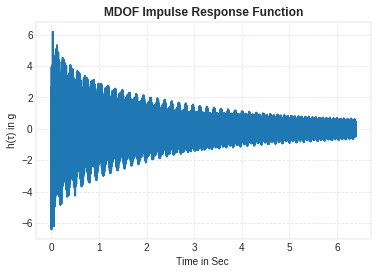

/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


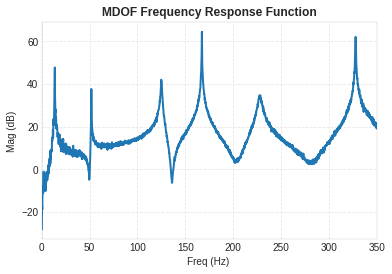

In [129]:
%matplotlib inline
mat_contents=sio.loadmat('SystemAnalysis/1.mat')

Frequency= mat_contents['Freq_domain']
Frequency= np.array(Frequency)
H = mat_contents['Hf_chan_2']


Time = mat_contents['Time_domain']
h = mat_contents['Time_chan_2']
             
fig=plt.figure()
plt.title('MDOF Impulse Response Function', fontweight='bold')
plt.plot(Time, (h))
plt.xlabel('Time in Sec ')
plt.ylabel('h(τ) in g')
plt.grid(True)
plt.show()

fig=plt.figure()
plt.title('MDOF Frequency Response Function', fontweight='bold')
plt.plot(Frequency,20*np.log10((H)))
plt.xlabel('Freq (Hz) ')
plt.ylabel('Mag (dB)')
plt.xlim(xmax=350, xmin=0)
plt.grid(True)
plt.show()

## Impulse response - Frequency weighting:

The impulse response from all the resonance combined gives a mixed decay curve not usable for an estimation of a specific resonance decay. The mixed decay curve is shown below:


**Note:** The reason behind putting the data in log scale is that the oscillation with exponential decay in linear scale becomes a straight line on the log scale that way it would be easier to calculate the decay if it had only one resonance, by just drawing a straight line joining the peaks of that resonance.

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


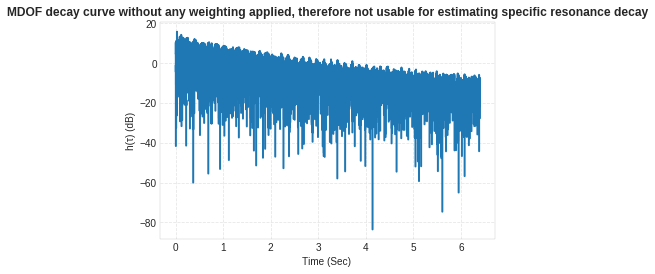

In [131]:
%matplotlib inline
fig=plt.figure()
plt.title("MDOF decay curve without any weighting applied, therefore not usable for estimating specific resonance decay", fontweight='bold')
plt.plot(Time, 20*np.log10(h))
plt.xlabel('Time (Sec) ')
plt.ylabel('h(τ) (dB)')
plt.grid(True)
plt.show()

However, if it is possible to do some filtering over one resonance to eliminated the others from the impulse response calculation then that will give a nice straight line. 

**Note: It is still a confusing thing to implement in Python. Python or Vibration Testing Experts may do this hard coding with ease. I would like to see someone fill this gap. So, as of now, this remains as an information in this notebook but this will be implemented in a while**

** Figure below gives the idea of applying weighting using a software**

![Ideal System(no noise)](img/weighting)


So, in the figure, observe the decay that corresponds to 8.7 dB on a dB scale that's for one time constant for the decay. 


**Reasons of using the weighting:**

- In the frequency domain, when a resonance has very little damping then the shape of the resonance would be very narrow, in that case, it would be difficult to estimate 3 dB band width accurately because the next point after or before the peak may be down by 7 or 8 or 9 dB.


- For a short resonance with very little damping, even if curve fitting can be done in a smart way, it becomes difficult. However, in the time domain, it is not an issue when there is very little damping, only thing that happens would be that the decay would be for a longer time. Hence, damping can be accurately measured in the time domain by applying the filter to see only one resonance at a time .


- The opposite is true if the damping is very high the the resonance in frequency domain is going to be wide, in that case it will be easy to go down accurately measure 3 dB band width. In the time domain, delta t error over time τ is very significant, so that's not a good way to calculate damping in this case.

**Feasibility of applying such a filter:**

It is important to keep in mind that here the main idea is to filter out all other resonances except the one chosen with a little window in the frequency domain as shown in the figure above but this method is only possible when the frequency response shows nice clean resonances that are well separated which means they are decoupled. Like in complex structures where they might have a few resonance at low frequency which are fine but when going up in frequency the modes get more and more closer to each other and that would be a mess. So, it is not feasible to use filters in that case to separate resonances. 

#### Demonstration of filtering out one resonance from the above data:

## Transducers and Exciters used:

A minimum of two channels are required to measure the signals coming out of the sensors simultaneously to do modal testing. Typically, Channel-1 corresponds to the impact hammer/electromagnetic shaker and Channel-2 to the accelerometer.

### Accelerometers: 


Accelerometers are very important in the process of data collection, there is nothing worst than using a pretty good transducer for a wrong job because that will not result in good data and could destroy the transducer if exceeds the range.


**Important Considerations to chose an optimum transducer**:

**1. Type:** 

There are three main types of accelerometers: capacitive MEMS, piezoelectric, and piezoresistive. The accelerometer's data sheet will, or should, tell the exact type because picking the right accelerometer type for any application can make all the difference.  Generally a capacitive MEMS accelerometer is best for motion sensing applications (think human motion which is relatively slow/low frequency); piezoelectric is best for vibration; and piezoresistive is best for shock testing.

**Figure below shows a bunch of accelerometers used in different applications**
![Ideal System(no noise)](img/accels)

**Piezoelectric Accelerometer:**
**Basic idea behind using piezoelectric ceramic element:** This element behaves like a quartz (pure quartz is used in standard reference accelerometers, less sensitivity but very stable) when applied compressive or shear stress then it 
generates a high-impedance, electric charge proportional to the applied force, and thus, proportional to the acceleration. Shear design is most commonly used. 


**Figure below shows a bunch of factors that would result in bad data collection, although only the one's rounded in red are most common in the Experimental Modal Analysis keeping in mind the fact that the testing would be done in Laboratory Environment **
![Ideal System(no noise)](img/envieffectss1)


**2. Weight:**

Every accelerometer is also a mass-spring system. Therefore, one big factor while doing modal analysis is Mass Loading(remember, Mass Loading is cumulative), so, if the dynamic mass of the accel is significant then that will change the natural frequencies of the system. Research says accelerometer mass has to be less than one tenth of mass of the system, that would be a good compromise to avoid major error in the recording of natural frequencies of the system. 


**Figure below shows an accelerometer mounted on a Mass-spring system**
![Ideal System(no noise)](img/massloading1)


**3. Sensitivity:** 

Sensitivity of an accelerometer defines at what rate the sensor converts mechanical energy into an electric signal (the output); and this will define the acceleration measurement range of the accelerometer.  Sensitivity is usually expressed as mV/g. Desired sensitivity depends on the level of the signal that is needed to be measured.  If interest lies in small vibrations then a higher sensitivity will be desirable to provide a cleaner signal (higher signal to noise ratio). The price to pay for a higher sensitive accelerometer is it's weight.

**Figure below illustrates how Weight, Sensitivity, Frequency range, and Measurement range of Accel relates to one another**
![Ideal System(no noise)](img/sensitivity1)

**4. Mounting:**

A stud in theory is the best method to mount an accelerometer but as sometimes when it's not possible then glue, adhesive tape, bees wax, dental cement, etc., are used.

**5. Cables:**

Rattling of cables on the structure, and interception with electric wires would cause noise that results in bad quality data as they are uncorrelated vibration.

**6. Others:** 

Other important considerations are Frequency response or Bandwidth, Measurement range, Noise, Resolution, Filtering, uni or triaxial etc.



#### TEDS Accelerometers:

TEDS stands for **Transducer Electronic Data sheet**, a chip that is embedded in the accelerometer containing all the Accel's information include Model Type number, Serial number, Sensitivity, Manufacture and more.

So, with TEDS transducers, all the relevant information is read from the chip and automatically entered in the database measurement setup avoiding mistakes and saving time. 


#### Validation:



This is a regular way of calibrating the accelerometer if it is dropped on the ground, the calibrator is usually standardized to check for 159.2 Hz frequency (1000 rad/sec) and 1g (10 meter per square second) acceleration.

#### Demonstration of Validating the Accelerometer used:

### Impact Hammers: (Non-attached)

Impact Hammers come in different sizes(1 pound, 3 pounds, 12 pounds and even bigger). The tip of the hammer can be unscrewed from the load cell and be replaced. That's the way the duration of the impact is controlled, and that pulse duration is inversely proportional to the Frequency bandwidth.

**Figure below shows different sizes of the Hammer. However, they can be much bigger depending on the size of the structure being excited**

![Ideal System(no noise)](img/hammers)




Magnitude and pulse duration depends on:

**1. Weight of hammer**

**2. Hammer tip (steel, plastic or rubber)**

**3. Dynamic characteristics of surface**

**4. Velocity at impact**



#### Demonstration of the impact, Soft Vs Hard:

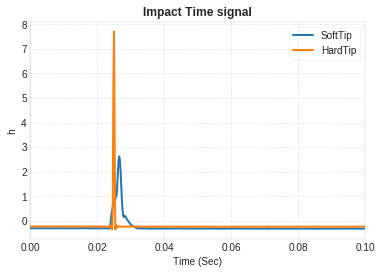

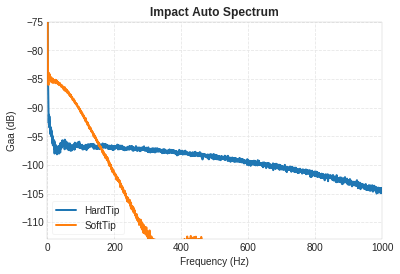

In [132]:
mat_contents=sio.loadmat('hammer/metaltip.mat')
Frequency= mat_contents['Freq_domain']
Metaltipimpactspec = mat_contents['PSD_chan_1']

Time = mat_contents['Time_domain']
Metaltipimpacttime = mat_contents['Time_chan_1']

Frequency= mat_contents['Freq_domain']
Metaltipimpactspec = mat_contents['PSD_chan_1']

mat_contents=sio.loadmat('hammer/plastictip2.mat')
Frequency= mat_contents['Freq_domain']
rubbertipimpactspec = mat_contents['PSD_chan_1']
Time = mat_contents['Time_domain']
rubbertipimpacttime = mat_contents['Time_chan_1']

Frequency= mat_contents['Freq_domain']
rubbertipimpactspec = mat_contents['PSD_chan_1']


fig=plt.figure()
plt.title('Impact Time signal', fontweight='bold')
plt.plot(Time, rubbertipimpacttime, label='SoftTip')
plt.plot(Time, Metaltipimpacttime, label='HardTip')
plt.xlabel('Time (Sec)')
plt.ylabel('h')
plt.grid(True)
plt.xlim(xmax=.1, xmin=0)
plt.legend()
plt.show()

fig=plt.figure()
plt.title('Impact Auto Spectrum', fontweight='bold')
plt.plot(Frequency, 20*np.log10(abs(Metaltipimpactspec)), label='HardTip')
plt.plot(Frequency, 20*np.log10(abs(rubbertipimpactspec)), label='SoftTip')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gaa (dB)')
plt.grid(True)
plt.xlim(xmax=1000, xmin=0)
plt.ylim(ymax=-75, ymin=-113)
plt.legend()
plt.show()



**Observations:** 

- It can be clearly seen that the narrower the duration of impact, the longer the spectrum in the frequency domain called broad band excitation. And the longer the duration of impact, the narrower the spectrum that is the spectrum rolls-off quickly. 


- The softer tip excites lower frequencies better than the harder tip, and the harder tip excites higher frequencies better.


- For the experiment on the wing structure, the softer tip is not appropriate since it drops at about 300 Hz. However, the hard tip tends to agree because there is equivalent amount of energy across the frequency of interest. Therefore, tips play a major role in this process.


**Advantages of the Hammer impact:** Speed, No fixturing, No variable mass loading, Portable and highly suitable for field work, relatively inexpensive, useful for determining shaker and support locations.


**Disadvantages:** High crest factor(underestimates the peak) which means possibility of driving structure into non-linear behavior, Tip performance is often overlooked, Not good for very large structures, Repeatable hammer strikes require 'calibrated elbow'.

**Note:** Metal tip when used on metallic structures can indent the structure, and goes non-linear. So, the impact needs to be really soft.





#### Validation:  

When there is a known mass with an accelerometer mounted on it and is impacted to get the FRF which is acceleration divided by force or one over the mass (F=m*a). 
This kind of test should give us the combined mass of the accelerometer and the calibrated mass. 
Care must be taken in maintaining consistency of units, it's easy in the SI system where the mass is in KGs, the measurement in meters and the force in Newtons. Should notice the phase to be flat if every thing is good.

**Figure below gives good idea to set up a test**
![Ideal System(no noise)](img/hamrvalidation)

#### Demonstration of Validating the Hammer used:

#### Demonstranting Double hit and the resulting ASD:

/home/sainag/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


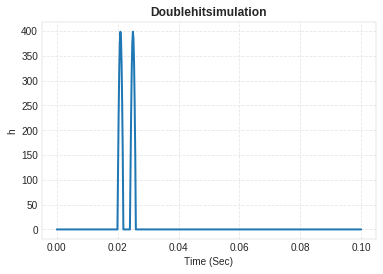

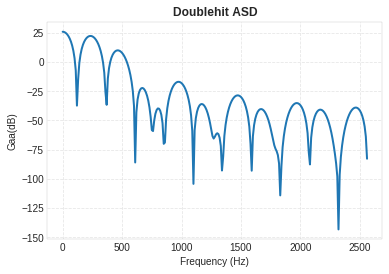

In [133]:
time= np.linspace(0,0.1,513).reshape(1,-1)
force= vt.hammer_impulse(time,imp_time=0.02,imp_duration=0.002,doublehit=True,dh_delta=0.04)
fig=plt.figure()
plt.title('Doublehitsimulation', fontweight='bold')
plt.plot(time.T, force.T)
plt.xlabel('Time (Sec)')
plt.ylabel('h')
plt.grid(True)
plt.legend()
plt.show()

[freq,Pff]=vt.asd(force,time,windowname="none")
freq= freq.reshape(1,257)

fig=plt.figure()
plt.title('Doublehit ASD', fontweight='bold')
plt.plot(freq.T, 20*np.log10(abs(Pff.T)))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gaa(dB)')
plt.grid(True)
plt.legend()
plt.show()

#### Ramifications of a double hit in an actual test:


The oscillations in the Hammer Auto spectrum occur due to double or multiple hits. This would add additional noise to the FRF. Peaks at natural frequencies can still be seen, however, additional fake peaks also appear in the FRF which would be confusing. And the mode shapes of the structure will look weird as those oscillation in the Hammer Auto spectrum adds extra contributions. Hence, double hits are not at all a compromise.  

#### Setting up the Hammer:



- The first thing is to determine how high of an impact that's intended to be generated, the idea being the identification of which level is above noise. However, the impact has to only be sufficiently high that they don't easily trigger on softer hits. So, before starting the test, running a free test and determining the trigger threshold would be  a good idea.


- **Hysteresis:** The hysteresis is quite optional, it prevents multiple triggers when the threshold is crossed. So, hysteresis may not be critical. Usually, 1/5th of the trigger level can be used for hysteresis. For instance, if trigger set up at 10 N then 2 N hysteresis would be fine.


- **Pre-trigger samples:** It is important to always make sure that the rise of the impact signal shall not be missed. Essentially, the entire impact pulse should be seen. This can be done by going back in time and getting data before triggering. That's called Pre-trigger, and a good rule of thumb is to fix that value to 5% of the block size which means 5% before trigger and 95% after the trigger.



#### Weighting Function for impact excitation: 

The purpose of the force window is to improve the signal-to-noise ratio of the measured input by eliminating the noise on the signal following the duration of the impact and also the noise on the signal before the impact.

**Figure gives an idea of how the window(in red) takes in only the pulse(in green) and zeros the rest of the signal thereby preventing any noise**
![alt](img/transient)

#### Demonstration of Force Window

### Electro-Magnetic Shakers (attached)

Electro-magnetic shaker is like a big speaker with a cone because these are built in the same way consisting of magnet, coil and suspension which drives them. For instance, a bigger shaker can play music but it will play like a poor speaker without a cone.

There are two types of shakers: **1. Modal Shakers and 2. General Purpose Shakers**

#### Modal Shakers

Excitation using modal shakers can give better results, more consistency when compared to the impact hammer.There have been number of methods over the years to excite the structure using a shaker. 


The shaker can be mounted horizontally for the excitation in horizontal direction. For vertical excitation, usually it is put on the floor or on the stack of ply-wood so that the structure can excite well, but horizontally it is so difficult to do that. That is the reason stand is provided to the shakers.

It is also true to mount it at some angle in order to excite all the three degrees of freedom at a time.

They have a robust design, can take beating for many years, and they come in different sizes.

**Figure below shows different sizes of Modal shaker**


![alt](img/shakers)



**Shaker specifications include:**  Force rate, Frequency range, Max. rated travel (inch peak-to-peak), Armature effective mass, weight with trunnion, Power Amplifier Type, DC static Centering Unit optional.


**Important things to know while Connecting shaker to a structure:**

- The thing to keep in mind is that when physically attaching  a shaker to the structure, the force transducer goes to the structure not on the shaker because the stringer which is attached or tied together between a force transducer and shaker is a filter to a degree and if the force transducer is before the stinger then it doesn't measure what goes on to the structure. So, it has to be on the structure.


- The shaker interior has a coil called the armature which has some physical characteristics due to it's weight. So, when attached to the structure that may add weight resulting in mass loading. That is one of the reasons shakers are normally used on very large objects so that the weight of the armature is not significant. To avoid this, there are also a low weight armature and those are good modal shakers which have magnesium armature that is light and stiff.  


- The goal of the stringer is to send all the force to the structure in the axis of interest, the stringers are designed to be infinitely stiff in the axial direction but allows cross motion as much as required in order to not prevent the structure from deforming one way or the other. So, these are the two requirement with the stringer, allow cross motion but being infinitely stiff in it's axial direction.


- The attachment point in the shaker to hold the stringer is a thru-hole. And the reason for that is because one of the very good ways of attaching the shaker to the structure is by using a piano wire which is a flexible wire. So, it is just to mount force transducer on the object and attach the stinger or piano wire down to that fixture, lock it in a way pre-tension it to the maximum. The piano wire is very stiff in push, pull but soft in cross axis. The minus point of using a piano wire instead of a stringer is that the range of frequencies could be only up to 200 Hz.


- When it comes to the force applied, it is important to try distributing the force if possible, this way it can prevent not to have extremely high force at only one point and not any where else, that is the reason behind using more number of shakers.


- Another thing we see about shaker is that, the attachment point is very small. The armature and head is designed for modal but not for fatigue testing. And, it is not ideal to use general purpose shakers for modal.


#### Modal Test set-up challenge:

**Case 1:** The ideal mounting method is the shaker being supported to produce force to an object which is floating. 

**Case 2:** Both the shaker and the object are floating.

**Case 3:** This is not a good idea as both are supported and the shaker is placed under the structure vertically, here the force transmits back. One should make sure that isolation is good to the force injecting into the structure and only goes to force transducer so that it measures well. Therefore, it is important to not have force behind the force transducer, this will give bad coherence resulting in bad results.


**Figure below gives a good idea of proper mounting technique**
![alt](img/shaker1)


**Important Note:** This issue was sorted out while doing the experiment, a close look at the first picture in the  notebook gives an idea of how the shaker resembles the third case here, and when that arrangement was used the coherence was never good. Since in our case the structure is clamped at one end and excitation has to be vertical, the shaker was placed on a thermocol for establishing free-free condition that closely resemble the reverse of the Case-1. But it still worked out perfectly.

**Figure below shows mounting method used for the modal test, what's exactly made is a proof mass actuator that is using the inertial load of the shaker to provide the force, this arrangement work equally well. It also mitigated the problems of the stringer bending side-to-side **

![alt](img/shaker)


**Advantages of the Shakers:** Repeatable due to electronic control, Wide range of excitations, Can excite very small thru very large structures, More automated test.


**Disadvantages:** More equipment required than hammer, Skilled operators necessary to supervise test, A lot of setup time required, Shaker issues such as: stringers, mounting of shaker, proper shaker selection.



#### Four steps to Modal Analysis with a shaker


**Step 1:** Excitation of the structure at one point by shaker with force transducer


**Step 2:** Response measured at a number of points


**Step 3:**  FRF’s between excitation point and measurement points calculated


**Step 4:** Modes of structure identified



#### Free Mass Validation: 



The same validation technique used for the impact hammer can be used with Shaker which is comparatively difficult. Test should witness that the phase and the FRF are flat or zero, if that is not the case then there may be a problem. 

**Figure below gives good idea to set up a test**
![alt](img/freemass)

#### Demonstration of validating the shaker used:

### Types of Excitations possible with the shaker:

#### 1. Sine Excitation:

Sine excitation runs at one amplitude and one frequency which means picking one point on the input and one on the output and that's what is being measured below.


#### Demonstration of Sine Excitation on the wing with 13.5 Hz Frequency at 6.128 Peak Amplitude:

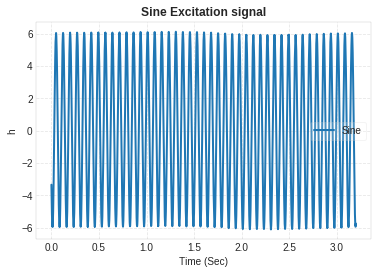

In [136]:

%matplotlib inline
mat_contents=sio.loadmat('sine/Sine.mat')


Gaa = mat_contents['PSD_chan_1']
Gbb = mat_contents['PSD_chan_2']
Time = mat_contents['Time_domain']
Sine = mat_contents['Time_chan_1']

mean = sum(Sine)/len(Sine)
Sine= Sine-mean

fig=plt.figure()
plt.title('Sine Excitation signal' , fontweight='bold')
plt.plot(Time, Sine, label='Sine')

plt.xlabel('Time (Sec)')
plt.ylabel('h')
plt.grid(True)

plt.legend()
plt.show()

Peak= np.max(Sine)

Peak_to_Peak= 2*Peak

RMS = np.max(Sine)/np.sqrt(2)

In [137]:
Peak

6.1286235

In [138]:
Peak_to_Peak

12.257246971130371

In [139]:
RMS

4.3335912259822775

In [140]:
Crest_factor_of_Sine_wave = np.max(Sine)/RMS
Crest_factor_of_Sine_wave

1.4142135623730951

#### Other possibilities with Sine Excitation:



With just Sine excitation, non-linearities of the structure is not taken into account. However, for non-linear studies measuring from low amplitudes and then increase it until a complete picture arrives, this will take long time because if for instance, 10 amplitudes per frequency times 400 frequencies then that counts to 4000 measurements, this can be either be done by writing the program or by collecting the data by accumulating all of that.

#### Sin Sweep across wide range of frequencies:

With Sine sweep across wide range of frequencies, **Modal Analysis can be performed without any signal processing issues.**

**Figure below show the time domain look of the sine sweep signal**

![alt](img/sinesweep1)

** Giving broadband excitation:** 

**Figure below demonstrates the broad band excitation of the sine sweep auto spectrum**

![alt](img/sweepauto1)
   - Sine wave swept slowly through the frequency range of interest
   - Quasi-stationary condition
    
**Advantages:**
    
   - Low Crest Factor
   - High Signal/Noise ratio
   - Input force well controlled
   - Study of non-linearities possible

**Disadvantages:**
    
   - Very slow
   - No linear approximation of non-linear system

#### Demonstration of Sine sweep:

#### 2. Random Excitation:

**Interesting facts about random excitation:**

- Using random excitation by definition means all the frequencies are present, there is no deterministic components, if zoomed-in no separations would be found. Amplitude and phase change randomly.


- Pure random noise can have excursion that are very high. So, normally it is required to limit the crest factor out of the generator to as limit.


- Interesting thing about random noise is that it can linearize slightly non-linear system. And averaging can reduce the random error. So, random excitation needs more averaging.


- One can easily tailor the range of the frequencies interested to excite and also zoom and move it at a different locations. So, it is convenient to excite only the frequency range of interest and ignoring others thereby not wasting energy out of the shaker. Knowing the frequency range tells where to put all the power and that is an advantage of control.


- It is really important to use Hanning Window while using random excitation as it would have leakage issue arising every time. This will be addressed in the Leakage section.


**Note:** when the structure is excited with the miniature shaker, the signal that comes out is called random noise. However, it's random excitation. Noise minimized here is external vibration or forces that are not coming out of the generator that disturb our measurement. So, that uncorrelated contribution from environmental vibration will be  reduce by averaging.

#### Demonstration of Random Excitation:

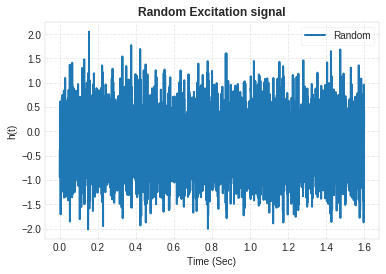

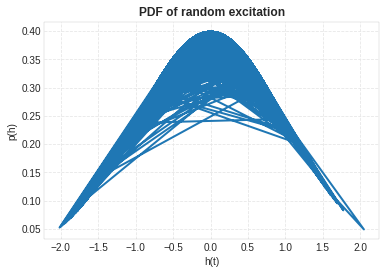

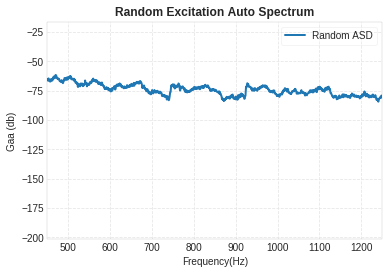

In [143]:
from scipy.stats import norm
%matplotlib inline
mat_contents=sio.loadmat('UsingShaker/1.mat')

Freq = mat_contents['Freq_domain']
Gaa = mat_contents['PSD_chan_1']
Gbb = mat_contents['PSD_chan_2']
Time = mat_contents['Time_domain']
Random = mat_contents['Time_chan_1']

fig=plt.figure()
plt.title('Random Excitation signal', fontweight='bold')
plt.plot(Time, Random, label='Random')
plt.xlabel('Time (Sec)')
plt.ylabel('h(t)')
plt.grid(True)
plt.legend()
plt.show()

fig=plt.figure()
plt.title('PDF of random excitation', fontweight='bold')
plt.plot(Random, norm.pdf(Random))
plt.xlabel('h(t)')
plt.ylabel('p(h)')
plt.grid(True)
plt.show()


fig=plt.figure()
plt.title('Random Excitation Auto Spectrum', fontweight='bold')
plt.plot(Freq, 20*np.log10(Gaa), label='Random ASD')
plt.xlabel('Frequency(Hz)')
plt.ylabel('Gaa (db)')
plt.grid(True)
plt.xlim(xmax=1250, xmin=450)
plt.legend()
plt.show()

**Modal Analysis can be performed using Random Excitation as well but should be careful with signal processing issues.**

**In summary:**

- Random variation of amplitude and phase  ==>  Averaging will give optimum linear estimate in case of non-linearities.


- Characterized by power spectral density (Gaa) and amplitude probability density (p(h))


- Can be band limited according to frequency range of interest 


- Signal not periodic in analysis time  ==>  Leakage in spectral estimates

**Advantages:**

- Best linear approximation of system


- Zoom


- Fair Crest Factor


- Fair Signal/Noise ratio

**Disadvantages:**

- Leakage


- Averaging needed (slower)

#### 3. Burst Random Excitation:

In Burst random, the signal is zero at the beginning and zero at the end, the vibration decays by itself. So, this avoid leakage significantly without windowing thereby helping to get good coherence. 

#### Demonstration of Burst Random Excitation:

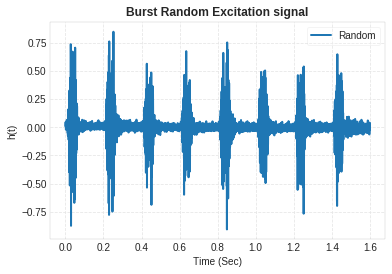

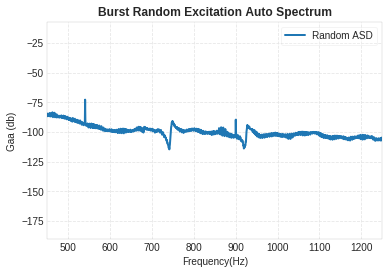

In [146]:

%matplotlib inline
mat_contents=sio.loadmat('burstrandom/18b.mat')

Freq = mat_contents['Freq_domain']
resp = mat_contents['Hf_chan_2']
Gaa = mat_contents['PSD_chan_1']
Gbb = mat_contents['PSD_chan_2']
Time = mat_contents['Time_domain']
Random = mat_contents['Time_chan_1']

mean = sum(Random)/len(Random)
Random= Random-mean

fig=plt.figure()
plt.title('Burst Random Excitation signal', fontweight='bold')
plt.plot(Time, Random, label='Random')
plt.xlabel('Time (Sec)')
plt.ylabel('h(t)')
plt.grid(True)
plt.legend()
plt.show()


fig=plt.figure()
plt.title('Burst Random Excitation Auto Spectrum', fontweight='bold')
plt.plot(Freq, 20*np.log10(Gaa), label='Random ASD')
plt.xlabel('Frequency(Hz)')
plt.ylabel('Gaa (db)')
plt.grid(True)
plt.xlim(xmax=1250, xmin=450)
plt.legend()
plt.show()


**Modal Analysis can be performed using this kind of excitation as well**

**Characteristics of Burst Random signal:**
    
   - Gives best linear approximation of nonlinear system
   
   
   - Works with zoom

**Advantages:**

   - Best linear approximation of system
   
   
   - No leakage (if rectangular time weighting can be used)
   
   
   - Relatively fast

**Disadvantages:**
   
   - Signal/noise and crest factor not optimum
   
   
   - Special time weighting might be required


#### 4. Pseudo Random Excitation:

Pseudo random is like a collection of sine waves at one amplitude. It's not purely random signal, considered as fake random. Therefore, unless there is a trust of how the structure works and is linear, better not to use Pseudo random excitation. Although, it is quick and has advantage of zooming in and move it at different locations.

So, it's basically the block of random signal repeated every T, this may not be seen well in the demonstrated real data.

**Figure below give an idea of the signal, as it is difficult to see this phenomena in the real data demonstrated below**

![alt](img/pseudo)

#### Demonstration of Pseudo Random Excitation:

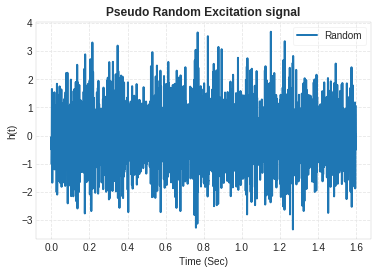

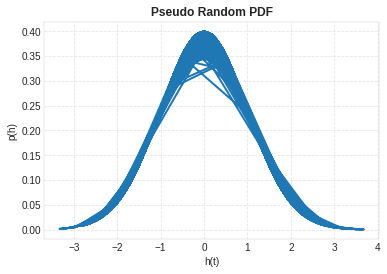

In [149]:
%matplotlib inline
mat_contents=sio.loadmat('pseudorandom/1Pseudo.mat')

Freq = mat_contents['Freq_domain']
Gaa = mat_contents['PSD_chan_1']
Gbb = mat_contents['PSD_chan_2']
Time = mat_contents['Time_domain']
Random = mat_contents['Time_chan_1']

mean = sum(Random)/len(Random)
Random= Random-mean

fig=plt.figure()
plt.title('Pseudo Random Excitation signal', fontweight='bold')
plt.plot(Time, Random, label='Random')
plt.xlabel('Time (Sec)')
plt.ylabel('h(t)')
plt.grid(True)
plt.legend()
plt.show()

fig=plt.figure()
plt.title('Pseudo Random PDF', fontweight='bold')
plt.plot(Random, norm.pdf(Random))
plt.xlabel('h(t)')
plt.ylabel('p(h)')
plt.grid(True)
plt.show()



**Unless we know the system is linear this kind of excitation may not be a good preference for doing Modal Analysis**


**In summary**

- Block of a random signal repeated every T


- Time period equal to record length T
  - Line spectrum coinciding with analyzer lines
  - No averaging of non-linearities
  
  
- Characterized by power/RMS (Gaa) and amplitude probability density (p(h))


- Can be band limited according to frequency range of interest


- Time period equal to T ==> No leakage if Rectangular weighting is used

**Advantages:** 
    
 - No leakage
 
 
 - Fast
 
 
 - Zoom
 
 
 - Fair crest factor
 
 
 - Fair Signal/Noise ratio

** Disadvantages:**

  - No linear approximation of non-linear system

#### Excitation technique: Important Considerations while selecting the type of excitation to proceed with:


- Application


- Non-linearities


- Speed of test


- Leakage (analysis)


- Dynamic range


- Crest factor


- Noise at input and/or output


- Equipment available

#### Guidelines for choice of excitation technique:


- For studying of non-linearities: Swept sine excitation


- For slightly non-linear system: Random excitation


- For perfectly linear system: Pseudo random excitation


- To minimize leakage: Burst random excitation


- For fields measurements: Impact excitation


- For high resolution field measurements: Random impact excitation

## Dual Channel FFT Analysis:

**What is really happening in the DAQ and the corresponding software while data collection?**

Assume channel.A corresponds to excitation and Channel.B to response, first step is to gather time data through the A/D converter and anti-aliasing filter, then do Fourier transformation to get a fourier spectrum and as averaging is being done signals multiply by themselves giving Gaa and Gbb (Autospectrum, has no phase) whose inverse fourier transform gives Auto correlation(Raa and Rbb). Both the signals from Fourier spectrum are brought together to calculate the Cross-spectrum(Gab) where phase is preserved. 
With the cross spectrum and the auto spectrum, the system calculates the FRF and the Coherence which are valuable functions. The other functions are not quite often used in Modal. Essentially, the FRF, the Coherence and the Impulse response(by taking inversed fourier transform of Frequency Response) are the major outcomes. 




**Figure shows the chart which makes it all clear**


![alt](img/dual)



**Note:** This chart has not been changed since 30 years. However, the number of channels have been considerably increased. From one excitation - one response to one excitation - multiple response to multiple excitation - multiple response. 

 





**Advantages of Dual-channel FFT Analysis:**

* Phase information is available. Phase gives complete description of the structure and it will let validate by doing proper animation as well.


* Effects of noise are minimized through AVERAGING. 


* A controlled input signal is not needed. So, controlling the excitation amplitude and frequency tightly is not a requirement because if the force spectrum is going up and down within like 20-30 dB, it's not a big deal because the transducer has a large dynamic range and also the front end (160 dB typically) so we can measure every thing accurately. The response will follow the excitation profile to some degree. And once we combine the two different signals together they will normalize.


* Easy tool to use once it is known how to set up the Analyzer.


* Extension, for instance to Modal Analysis.

**Pitfalls of Dual-channel FFT Analysis:**

* Leakage


* A linear system is assumed


###  Leakage:

 

It is the result of underestimating the peak either at the valley or at the resonance.

** To prevent leakage:**

-    Use optimum time weighting function


-    Increase the resolution


-    Choose optimum excitation


#### 1. Using Optimum time weighting function:



 It is a result of not having time data acquisition until infinite time. However, in reality, there is the beginning and the end. So, it is important to add some weighting to prevent leakage.


**Ideal Case**: It almost never happens for a signal like sine wave containing even number of cycles which means that the beginning and the end of time is continuous. Because the FFT process takes that time data block, loop it and analyze constantly so it looks perfectly continuous and thats the ideal case which do not require windowing to prevent leakage. If window is added to that case then that would over estimate damping making the mode look wider than it should be.

**Figure shows how windowing an ideal signal would over estimate the damping parameter**


![alt](img/idealcase1)


**Real cases require window to prevent leakage to some extent**: Real world time data is collected as a block which has a size and is not continuous at the beginning and the end. When FFT is done then there will be a drop in amplitude, poor spectrum filter profile. So, it requires weighting functions to control leakage as much as possible.  

**Figure shows how windowing helps in preventing leakage**
![alt](img/realcase1)

#### Demonstration of windowing with Exponential for Impact time response and Hanning for Random response:

expwin is untested


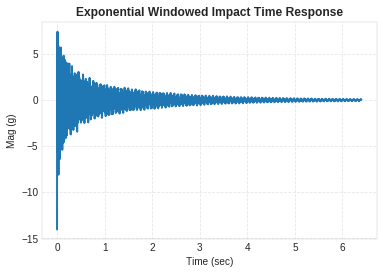

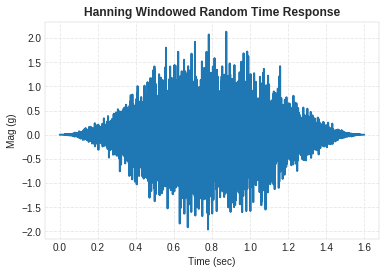

In [150]:
%matplotlib inline
mat_contents=sio.loadmat('modaldata/rawdata_1.mat')
Time_data= mat_contents['Time_domain']
Time_data= np.array(Time_data)
a=vt.expwin(len(Time_data),ts=2)
Time_data= np.transpose(Time_data)
rawresponse1= mat_contents['Time_chan_2']
rawresponse1 = np.array(rawresponse1)
windowedsig= np.transpose(rawresponse1)*a

fig=plt.figure()
plt.title('Exponential Windowed Impact Time Response', fontweight='bold')
plt.plot(Time_data.T, windowedsig.T)
plt.xlabel('Time (sec)')
plt.ylabel('Mag (g)')
plt.grid(True)

mat_contents=sio.loadmat('linearitycheck/high.mat')
Time_data= mat_contents['Time_domain'] 
Time_data= np.array(Time_data)
a=vt.hanning(len(Time_data))
averagedsig= mat_contents['Time_chan_2']
Time_data= np.transpose(Time_data)

averagedsig = np.array(averagedsig)
windowedsig= np.transpose(averagedsig)*a
fig=plt.figure()
plt.title('Hanning Windowed Random Time Response', fontweight='bold')
plt.plot(Time_data.T, windowedsig.T)
plt.xlabel('Time (sec)')
plt.ylabel('Mag (g)')
plt.grid(True)

#### Demonstrating window effecting the spectrum as explained above:

expwin is untested


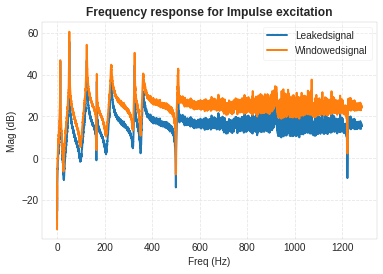

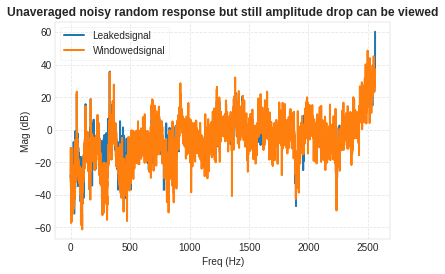

In [151]:
%matplotlib inline
mat_contents=sio.loadmat('modaldata/rawdata_1.mat')
Time_data= mat_contents['Time_domain']
Time_data= np.array(Time_data)
a=vt.expwin(len(Time_data))
Time_data= np.transpose(Time_data)
rawimpact1 = mat_contents['Time_chan_1']
rawimpact1 = np.array(rawimpact1)
rawresponse1= mat_contents['Time_chan_2']
rawresponse1 = np.array(rawresponse1)
windowedresponse1= np.transpose(rawresponse1)*a

x=np.array([rawresponse1]).reshape(1,16384,1)

xwindowed=np.array([windowedresponse1]).reshape(1,16384,1)

f=np.array([rawimpact1]).reshape(1,16384,1)

[freq,Pxx]=vt.asd(x,Time_data,windowname="none")
[freq,Pff]=vt.asd(f,Time_data,windowname="none")
[freq,Pxf]=vt.crsd(f,x,Time_data,windowname="none")

[freq,Pxxwindowed]=vt.asd(xwindowed,Time_data,windowname="none")
[freq,Pxfwindowed]=vt.crsd(f,xwindowed,Time_data,windowname="none")

Pxx= np.array([Pxx]).reshape(1,8193)

freq=np.array([freq]).reshape(1,8193)

freq=np.array(freq)
H1=np.conj(Pxf/Pff)
H1=np.array([H1]).reshape(1,8193)
H1=np.array(H1)

H1windowed=np.conj(Pxxwindowed/Pxfwindowed)
H1windowed=np.array([H1windowed]).reshape(1,8193)

FRFs= np.column_stack((H1,H1windowed))
FRFs=np.array(FRFs)


fig = plt.figure()
ax = plt.subplot(111)
ax.plot(freq.T, 20*np.log10(abs(H1)).T, label='Leakedsignal')
ax.plot(freq.T, 20*np.log10(abs(H1windowed)).T, label='Windowedsignal')
plt.title('Frequency response for Impulse excitation', fontweight='bold')
plt.xlabel('Freq (Hz)')
plt.ylabel('Mag (dB)')
ax.legend()
plt.grid(True)
plt.show()

mat_contents=sio.loadmat('linearitycheck/high.mat')
Time_data= mat_contents['Time_domain']
Time_data= np.array(Time_data)
a=vt.hanning(len(Time_data))
Time_data= np.transpose(Time_data)
rawimpact1 = mat_contents['Time_chan_1']
rawimpact1 = np.array(rawimpact1)
rawresponse1= mat_contents['Time_chan_2']

rawresponse1 = np.array(rawresponse1)
windowedresponse1= np.transpose(rawresponse1)*a


x=np.array([rawresponse1]).reshape(1,8192,1)


xwindowed=np.array([windowedresponse1]).reshape(1,8192,1)

f=np.array([rawimpact1]).reshape(1,8192,1)

[freq,Pxx]=vt.asd(x,Time_data,windowname="none")
[freq,Pff]=vt.asd(f,Time_data,windowname="none")
[freq,Pxf]=vt.crsd(f,x,Time_data,windowname="none")

[freq,Pxxwindowed]=vt.asd(xwindowed,Time_data,windowname="none")
[freq,Pxfwindowed]=vt.crsd(f,xwindowed,Time_data,windowname="none")

Pxx= np.array([Pxx]).reshape(1,4097)

freq=np.array([freq]).reshape(1,4097)
freq=np.array(freq)
H1=np.conj(Pxf/Pff)
H1=np.array([H1]).reshape(1,4097)
H1=np.array(H1)
H1windowed=np.conj(Pxxwindowed/Pxfwindowed)
H1windowed=np.array([H1windowed]).reshape(1,4097)
FRFs= np.column_stack((H1,H1windowed))
FRFs=np.array(FRFs)


fig = plt.figure()
ax = plt.subplot(111)
ax.plot(freq.T, 20*np.log10(abs(H1)).T, label='Leakedsignal')
ax.plot(freq.T, 20*np.log10(abs(H1windowed)).T, label='Windowedsignal')
plt.title('Unaveraged noisy random response but still amplitude drop can be viewed', fontweight='bold')
plt.xlabel('Freq (Hz)')
plt.ylabel('Mag (dB)')
ax.legend()
plt.grid(True)
plt.show()

#### Exponential weighting:



Basically, with exponential window, some decay can be added without killing the whole signal. Exponential window can also be avoided if more time is allowed for the measurement. It works both way, either compensate for the weighting later or measure more time, as it is demonstrated and explained below:

#### Demonstration of exponential window over a SDOF impulse response function:

expwin is untested


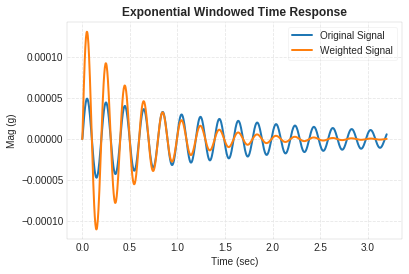

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log10


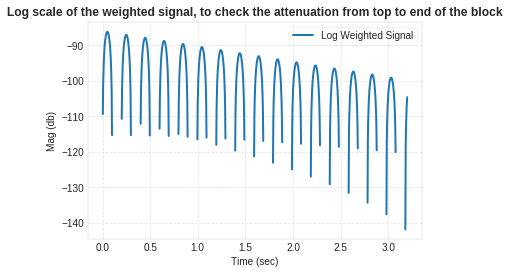

In [153]:
sys = vt.so2ss(np.array([[1]]),np.array([[1]]),np.array([[1000]]),
               np.array([[1]]),np.array([[1]]), np.array([[0]]), np.array([[0]]))
sys = ctrl.ss(*sys)
U = np.zeros((1,1000))
U[0,0]=1
X0=np.array([[0],[0]])
T = np.linspace(0,3.2,1000)
T, yout, xout = ctrl.forced_response(sys,U=U,T=T,X0=X0)


a=vt.expwin(len(T),ts=0.75)
windowedsig= np.transpose(yout)*a
T= T.reshape(1,1000)

fig=plt.figure()
plt.title('Exponential Windowed Time Response', fontweight='bold')

plt.plot(T.T,yout.T, label='Original Signal')
plt.plot(T.T, windowedsig.T, label= 'Weighted Signal')

plt.xlabel('Time (sec)')
plt.ylabel('Mag (g)')
plt.grid(True)
plt.legend()
plt.show()

fig=plt.figure()
plt.title('Log scale of the weighted signal, to check the attenuation from top to end of the block', fontweight='bold')
plt.plot(T.T, 20*np.log10(yout.T), label= 'Log Weighted Signal')

plt.xlabel('Time (sec)')
plt.ylabel('Mag (db)')
plt.grid(True)
plt.legend()
plt.show()

**Importance of viewing in Log Scale:** 

If the weighted signal is converted to log scale, then the amount of attenuation from the top to the end of the block can be seen, the rule of thumb could be if there is less than or equal to 50 dB attenuation from the top to the end then it's good enough to apply weighting. So,  too much external weighting to the signal could kill the good signal, so it's better to not apply weighting. The log graph plotted above shows that there is around 20 dB attenuation that can be good value to have which means that the beginning and the end are pretty close and that would minimize leakage when weighting is applied. 

**Correction:**
- The goal of exponential window is to fit the entire signal inside the window, which means that the amplitude at the end is zero. 


- With exponential weighting of the output signal, the measured time constant will be too short and the calculated decay constant and damping ratio therefore too large. A correction for exponential weighting is required as shown below.

**Figure below shows both the weighted and the true signal along with the correction factor for damping that needs to be applied**
![alt](img/weighting1)


![alt](img/compensation1)


**Note:** 
- In addition to choosing exponential window, it is important to keep in mind that measuring for too short duration could result in loosing good data by accident.


- The common mistake is to say that damping is added to the signal when windows are used but it's not damping, it actually adding decay to the signal.

#### 2. Leakage due to low Resolution: 



 when resolution is low, that means there are less points to represent the curves digitally and these points need not necessarily be at the maximum. So, this could cause a reduction in amplitude underestimating the peak either at the resonance or the valley or both. 


Hence, in order to reduce the leakage due the resolution it has to be increased which means data needs to be measured for longer period of time. Leakage can also be reduced by choosing H2 for resonance and H1 for the anti-resonance.


#### Demonstrating leakage due to resolution with Random Excitation:


- Shaker was ran in random mode and seen the impact of different acquisition settings on the coherence and noticed how this can have significant changes to the system.


- Initialized the test by setting a safe voltage level for the shaker by scrolling the bar up and down to adjust in terms of percentage for security reasons, here 100% was used and it's fine to use full voltage if the sytem is considerably big to shake with that high force. However, if a satellite is being tested which costs millions of dollar then care must be taken.


- So, the pure random excitation upto 2KHz was used with a poor frequency resolution of 8Hz which means the measurement had been for 1/8th of a second. 


- Then, ran  the random again as a second case for 1.6 seconds which is 1/1.6 Hz resolution which is higher. And the demonstration and observations are explained below:

(100, 300)

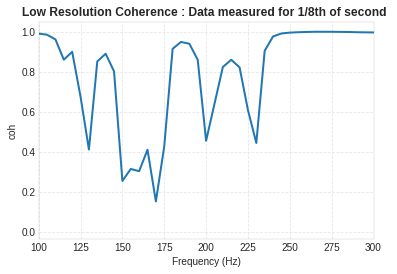

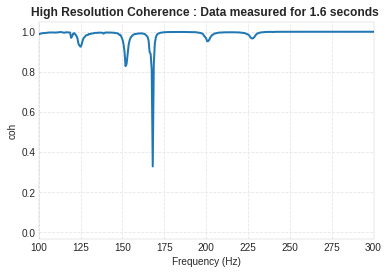

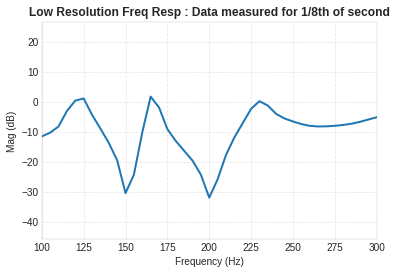

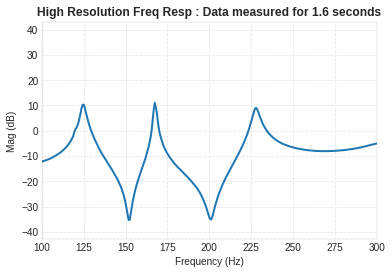

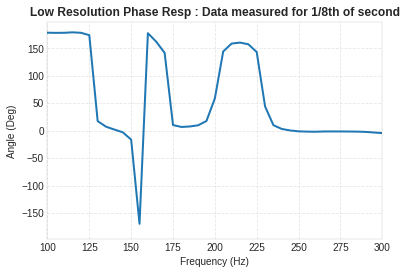

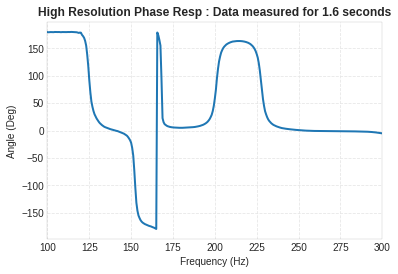

In [154]:
%matplotlib inline
mat_contents=sio.loadmat('Resolution/highresolution.mat')
Frequencyhigh= mat_contents['Freq_domain']
Frequencyhigh= np.array(Frequencyhigh)
#Frequency= np.transpose(Frequency)
Highresolutionresponse = mat_contents['Hf_chan_2']
Highresolutionresponse = np.array(Highresolutionresponse)
coh = mat_contents['Hf_coh_chan_2']
cohhighresolution = np.array(coh)

mat_contents=sio.loadmat('Resolution/Lowresolution.mat')
Frequencylow= mat_contents['Freq_domain']
Frequencylow= np.array(Frequencylow)
lowresolutionresponse = mat_contents['Hf_chan_2']
lowresolutionresponse = np.array(lowresolutionresponse)
coh = mat_contents['Hf_coh_chan_2']
cohlowresolution = np.array(coh)

fig=plt.figure()
plt.title('Low Resolution Coherence : Data measured for 1/8th of second ', fontweight='bold')
plt.plot(Frequencylow, cohlowresolution)
plt.xlabel('Frequency (Hz)')
plt.ylabel('coh')
plt.grid(True)
plt.xlim(xmax=300, xmin=100)

fig=plt.figure()
plt.title('High Resolution Coherence : Data measured for 1.6 seconds ', fontweight='bold')
plt.plot(Frequencyhigh, cohhighresolution)
plt.xlabel('Frequency (Hz)')
plt.ylabel('coh')
plt.grid(True)
plt.xlim(xmax=300, xmin=100)

fig=plt.figure()
plt.title('Low Resolution Freq Resp : Data measured for 1/8th of second', fontweight='bold')
plt.plot(Frequencylow, 20*np.log10(abs(lowresolutionresponse)))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid(True)
plt.xlim(xmax=300, xmin=100)

fig=plt.figure()
plt.title('High Resolution Freq Resp : Data measured for 1.6 seconds', fontweight='bold')
plt.plot(Frequencyhigh, 20*np.log10(abs(Highresolutionresponse)))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid(True)
plt.xlim(xmax=300, xmin=100)

fig=plt.figure()
plt.title('Low Resolution Phase Resp : Data measured for 1/8th of second', fontweight='bold')
plt.plot(Frequencylow, np.degrees(np.angle(lowresolutionresponse)))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Angle (Deg)')
plt.grid(True)
plt.xlim(xmax=300, xmin=100)

fig=plt.figure()
plt.title('High Resolution Phase Resp : Data measured for 1.6 seconds', fontweight='bold')
plt.plot(Frequencyhigh, np.degrees(np.angle(Highresolutionresponse)))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Angle (Deg)')
plt.grid(True)
plt.xlim(xmax=300, xmin=100)





**Observations:**
- It can be seen that the FRFs are not clean and look rugged at low resolution and coherence has big drops at resonances. So, it has very poor definition around the resonance because of very few points there. This is also apparent in phase plots.


- As the FRF plotted here corresponds to H1, there is no significant leakage at anti-resonances.





## Tests for validation of data:



**1. Coherence**


**2. Linearity**


**3. Reciprocity**


**4. Drive Point**


### 1. Coherence: (Input-Output Relation):

This is a rule to always make sure the coherence is "1" or very close to 1 at the resonance. Coherence tells us how good is the measurement in terms of linearity, quality of the impact, and noise. So, it's a very valuable function. 

***Note***: Do not be too concerned if the coherence is something less than "1" at the anti-resonance.

**Figure below shows the Ideal system with coherence 1**
![Ideal System(no noise)](img/Idealsystem)

**Figure below shows the Influence of noise that damage the FRF, thereby lowering the coherence**
![Ideal System](img/Influenceofnoise1)



#### Averaging: 



If there is little bit of unwanted environmental noise, that means the magnitude of the vector A or B or both would go bigger or smaller, this can be seen in their respective auto spectrum.

**Input Auto spectrum:** Auto spectrum means signal multiplied to itself. So, when input noise M is multiplied by itself becomes correlated and the noise contribution add to the true input signal.



![Alt](img/Saa)



**Output Auto spectrum:** Any of the auto spectrum includes noise contribution. Here N is output noise.



![Ideal System(no noise)](img/Sbb)



**Cross-Spectrum:** The cross spectrum can get the true signal as noise will keep canceling out through averaging. Because every time we multiply two signals that are uncorrelated like noise, the averaging result would be zero because the phase and amplitude both are random.



![Ideal System(no noise)](img/Sab)






### How many number of averages to be taken in impact test:

 Depends on level of noise present during the test. In case of the wing structure, the accelerometer sensitivity was 100 mv/g, the structure is not so big and the vibration due to impact(using hammer) was sufficient to get a cleaner signal. So, only three data sets were averaged. However, for a transducer with 1 mv/g on a big structure and small excitation level, there is a very little vibration. So, the noise is going to be significant in amplitude compared to vibration, this will be problematic. 

In that case not many options exist, so we might use FRF estimators assuming that could solve the issue. This is demonstrated and explained below.

#### Demonstration of three data sets being averaged to reduce noise:

(0, 350)

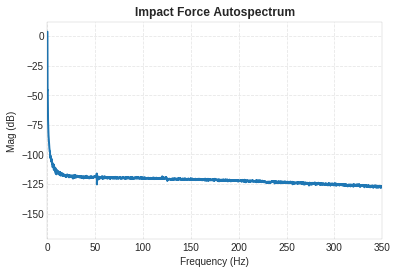

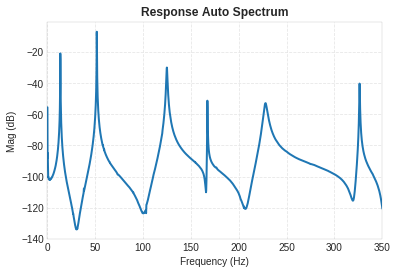

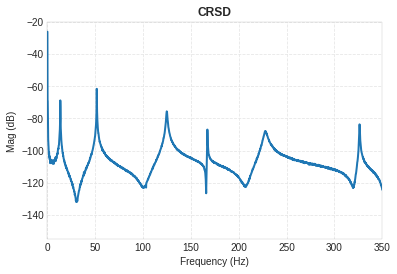

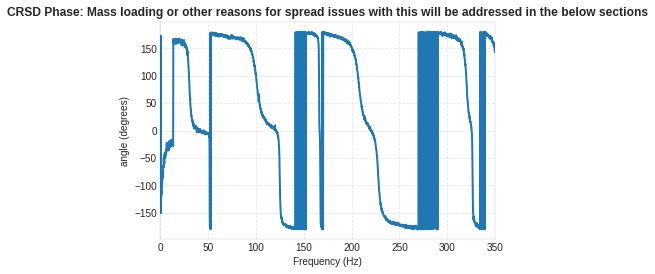

In [174]:
%matplotlib inline
mat_contents=sio.loadmat('modaldata/rawdata_1.mat')
Time_data= mat_contents['Time_domain']
Time_data= np.array(Time_data)
Time_data= np.transpose(Time_data)
rawimpact1 = mat_contents['Time_chan_1']
rawimpact1 = np.array(rawimpact1)
rawresponse1= mat_contents['Time_chan_2']
rawresponse1 = np.array(rawresponse1)
mat_contents=sio.loadmat('modaldata/rawdata_2.mat')
rawimpact2 = mat_contents['Time_chan_1']
rawimpact2 = np.array(rawimpact2)
rawresponse2= mat_contents['Time_chan_2']
rawresponse2 = np.array(rawresponse2)
mat_contents=sio.loadmat('modaldata/rawdata_3.mat')
rawimpact3 = mat_contents['Time_chan_1']
rawimpact3 = np.array(rawimpact3)
rawresponse3= mat_contents['Time_chan_2']
rawresponse3 = np.array(rawresponse3)

x= np.column_stack((rawresponse1,rawresponse2,rawresponse3))
x=np.array([x]).reshape(1,16384,3)

f= np.column_stack((rawimpact1,rawimpact2,rawimpact3))
f=np.array([f]).reshape(1,16384,3)

[freq,Pxx]=vt.asd(x,Time_data,windowname="none")

[freq,Pff]=vt.asd(f,Time_data,windowname="none")

[freq,Pxf]=vt.crsd(f,x,Time_data,windowname="none")

freq=np.array([freq]).reshape(1,8193)


fig=plt.figure()
plt.title('Impact Force Autospectrum', fontweight='bold')
plt.plot(freq.T, 20*np.log10(abs(Pff)).T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid(True)
plt.xlim(xmax=350, xmin=0)

fig=plt.figure()
plt.title('Response Auto Spectrum', fontweight='bold')
plt.plot(freq.T, 20*np.log10(abs(Pxx)).T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid(True)
plt.xlim(xmax=350, xmin=0)

fig=plt.figure()
plt.title('CRSD', fontweight='bold')
plt.plot(freq.T, 20*np.log10(abs(Pxf)).T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid(True)
plt.xlim(xmax=350, xmin=0)

fig=plt.figure()
plt.title('CRSD Phase: Mass loading or other reasons for spread issues with this will be addressed in the below sections', fontweight='bold')
plt.plot(freq.T, np.degrees(np.angle(Pxf).T))
plt.xlabel('Frequency (Hz)')
plt.ylabel('angle (degrees)')
plt.grid(True)
plt.xlim(xmax=350, xmin=0)


#### FRF Alternative Estimators:  



If the coherence is good then either H1 or H2 can be chosen, the default FRF is H1. 

**Figure below shows a more accurate estimator table used for different compromises that the system has to under go because of signal processing issues**

![alt](img/estimates1)


#### Demonstration of H1, H2, Coherence:

(0, 350)

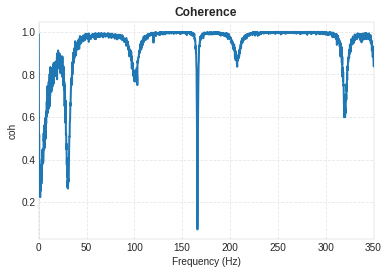

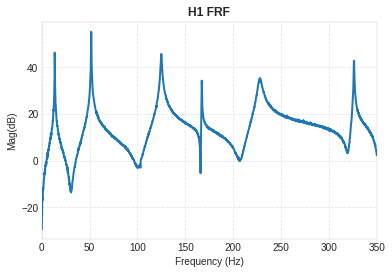

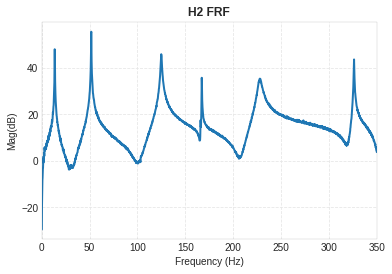

In [165]:
H1=np.conj(Pxf/Pff)
H2=Pxx/Pxf
coh=(Pxf*np.conj(Pxf)).real/Pxx/Pff

fig=plt.figure()
plt.title('Coherence', fontweight='bold')
plt.plot(freq.T, coh.T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('coh')
plt.grid(True)
plt.xlim(xmax=350, xmin=0)

fig=plt.figure()
plt.title('H1 FRF', fontweight='bold')
plt.plot(freq.T, 20*np.log10(abs(H1)).T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag(dB)')
plt.grid(True)
plt.xlim(xmax=350, xmin=0)

fig=plt.figure()
plt.title('H2 FRF', fontweight='bold')
plt.plot(freq.T, 20*np.log10(abs(H2)).T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag(dB)')
plt.grid(True)
plt.xlim(xmax=350, xmin=0)


**Observations:**  

- Observing that the coherence obtained which is almost 0.9 at resonances but hit spots where the coherence is low and that would happen at the anti-resonances. Depending on how the modes add or subtract,  the FRF can have these deep valleys and these deep valleys indicate that there is very little vibration, so small, we may be very close to the environmental noise and coherence tells that. However, it's not bad to have low coherence at anti-resonance. 


- Closer look at H1 and H2 proves the fact that one is good at anti-resonance and one at resonance.




#### Typical reasons for Low Coherence: 


*** Difficult measurements:***
- Noise in measured output signal


- Noise in measured input signal


- Other inputs not correlated with measured input signal



*** Bad measurements:***
- Leakage


- Time varying systems


- Non-linearities of system


- DOF-jitter

### 2. Linearity Checks:



A structure's FRF is independent of the level of excitation if it is linear. So, the Linearity check is done by exciting the structure at various levels obtaining the same values for the FRF.

**Figure below give an idea of how linearity check works**
![alt](img/Linearity1)



#### Averaging of the random signal:

 The averaging is also very useful when the excitation used is random, which means that the excitation varies in amplitudes randomly, and the response will follow. The input-output relation should be a straight line if the system is linear (double the excitation, double the response). And if we have some random errors going every where then averaging would give the best fit for the relationship.

#### Demonstration of linearity check with three different levels of random excitation or noise:

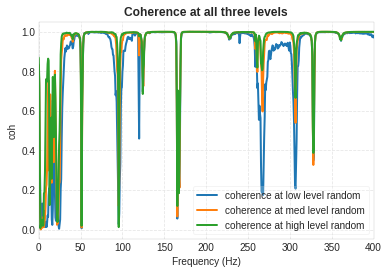

/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


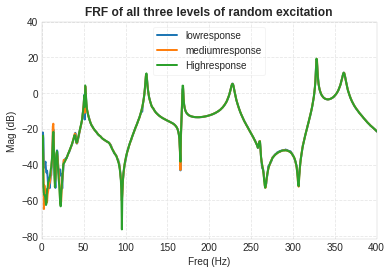

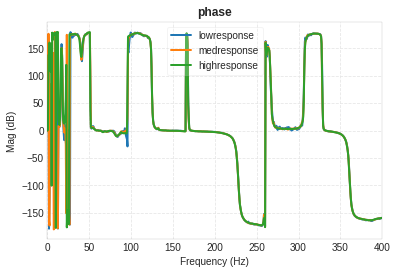

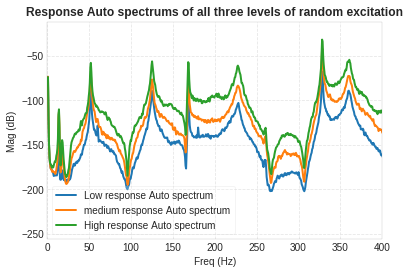

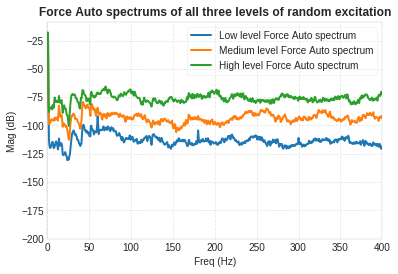

In [167]:
%matplotlib inline
mat_contents=sio.loadmat('linearitycheck/high.mat')
Frequency= mat_contents['Freq_domain']
Frequency= np.array(Frequency)
Highresponse = mat_contents['Hf_chan_2']
Highresponse = np.array(Highresponse)
PSDHighresponse = mat_contents['PSD_chan_2']
PSDHighresponse = np.array(PSDHighresponse)
PSDHighLevelRandom = mat_contents['PSD_chan_1']
PSDHighLevelRandom = np.array(PSDHighLevelRandom)
coh = mat_contents['Hf_coh_chan_2']
Highcoh = np.array(coh)

mat_contents=sio.loadmat('linearitycheck/med.mat')

mediumresponse = mat_contents['Hf_chan_2']
mediumresponse = np.array(mediumresponse)
PSDmediumresponse = mat_contents['PSD_chan_2']
PSDmediumresponse = np.array(PSDmediumresponse)
PSDmediumLevelRandom = mat_contents['PSD_chan_1']
PSDmediumLevelRandom = np.array(PSDmediumLevelRandom)
coh = mat_contents['Hf_coh_chan_2']
Medcoh = np.array(coh)

mat_contents=sio.loadmat('linearitycheck/low.mat')

lowresponse = mat_contents['Hf_chan_2']
lowresponse = np.array(lowresponse)
PSDlowresponse = mat_contents['PSD_chan_2']
PSDlowresponse = np.array(PSDlowresponse)
PSDlowLevelRandom = mat_contents['PSD_chan_1']
PSDlowLevelRandom = np.array(PSDlowLevelRandom)
coh = mat_contents['Hf_coh_chan_2']
Lowcoh = np.array(coh)

FRFs= np.column_stack((lowresponse,mediumresponse,Highresponse))
VibAutospectrum= np.column_stack((PSDlowresponse,PSDmediumresponse,PSDHighresponse))
ForceAutospectrum= np.column_stack((PSDlowLevelRandom,PSDmediumLevelRandom,PSDHighLevelRandom))
coh= np.column_stack((Highcoh, Medcoh, Lowcoh))
coh= np.array(coh)
FRFs=np.array(FRFs)
VibAutospectrum=np.array(VibAutospectrum)
ForceAutospectrum=np.array(ForceAutospectrum)

fig=plt.figure()
plt.title('Coherence at all three levels', fontweight='bold')
plt.plot(Frequency, Lowcoh,label='coherence at low level random')
plt.plot(Frequency, Medcoh,label='coherence at med level random')
plt.plot(Frequency, Highcoh,label='coherence at high level random')
plt.xlim(xmax=400, xmin=0)
plt.xlabel('Frequency (Hz)')
plt.ylabel('coh')
plt.grid(True)
plt.legend()
plt.show()


fig=plt.figure()
plt.title('FRF of all three levels of random excitation', fontweight='bold')

plt.plot(Frequency,20*np.log10(lowresponse), label='lowresponse')
plt.plot(Frequency, 20*np.log10(mediumresponse), label= 'mediumresponse')
plt.plot(Frequency, 20*np.log10(Highresponse), label= 'Highresponse')

plt.xlabel('Freq (Hz)')
plt.ylabel('Mag (dB)')
plt.xlim(xmax=400, xmin=0)
plt.grid(True)
plt.legend()
plt.show()

fig=plt.figure()
plt.title('phase', fontweight='bold')
plt.plot(Frequency, np.degrees(np.angle(lowresponse)), label='lowresponse')
plt.plot(Frequency, np.degrees(np.angle(mediumresponse)), label='medresponse')
plt.plot(Frequency, np.degrees(np.angle(Highresponse)), label='highresponse')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid(True)
plt.legend()
plt.xlim(xmax=400, xmin=0)
plt.show()

fig=plt.figure()
plt.title('Response Auto spectrums of all three levels of random excitation', fontweight='bold')

plt.plot(Frequency,20*np.log10(PSDlowresponse), label='Low response Auto spectrum')
plt.plot(Frequency, 20*np.log10(PSDmediumresponse), label= 'medium response Auto spectrum')
plt.plot(Frequency, 20*np.log10(PSDHighresponse), label= 'High response Auto spectrum')

plt.xlabel('Freq (Hz)')
plt.ylabel('Mag (dB)')
plt.xlim(xmax=400, xmin=0)
plt.grid(True)
plt.legend()
plt.show()

fig=plt.figure()
plt.title('Force Auto spectrums of all three levels of random excitation', fontweight='bold')

plt.plot(Frequency,20*np.log10(PSDlowLevelRandom), label='Low level Force Auto spectrum')
plt.plot(Frequency, 20*np.log10(PSDmediumLevelRandom), label= 'Medium level Force Auto spectrum')
plt.plot(Frequency, 20*np.log10(PSDHighLevelRandom), label= 'High level Force Auto spectrum')

plt.xlabel('Freq (Hz)')
plt.ylabel('Mag (dB)')
plt.xlim(xmax=400, xmin=0)
plt.grid(True)
plt.legend()
plt.show()


**Observations:**
 
 
 - We can see at all the levels of the excitation the FRF remains constant which means the system exhibits linear behavior. However, zooming in closely we can find rugged edges in the FRF which is not good at all. 
 
 
 - If we look at the coherence we can choose the best FRF by zooming in, notice that the green signal looks better which is at high level force. So, coherence looks much better with sufficient amount of force.

### 3. Reciprocity Checks:



"Maxwell's Reciprocity Theorem" simply stated, a measurement with the excitation at point A and response at point B is equal to the measurement with excitation at point B and the response at point A. So, if the structure is linear then the reciprocity will be good.

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6e7215f438>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6e72516860>)

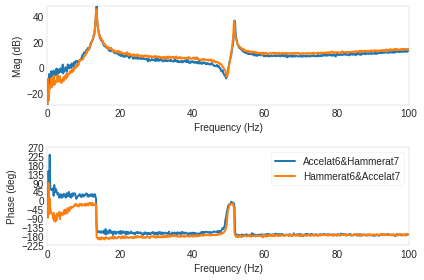

In [168]:
%matplotlib inline
mat_contents=sio.loadmat('reciprocity/accelat6&hammerat7/3.mat')
Frequency= mat_contents['Freq_domain']
Frequency= np.array(Frequency)
FRFat6 = mat_contents['Hf_chan_2']
FRFat6 = np.array(FRFat6)

mat_contents=sio.loadmat('reciprocity/hammerat6&accelat7/1-1.mat')
Frequency= mat_contents['Freq_domain']
Frequency= np.array(Frequency)
FRFat7 = mat_contents['Hf_chan_2']
FRFat7 = np.array(FRFat7)

FRFs= np.column_stack((FRFat6,FRFat7))
FRFs=np.array(FRFs)

vt.frfplot(Frequency,FRFs,freq_min=0,freq_max=100,type=1,legend=['Accelat6&Hammerat7','Hammerat6&Accelat7'])



### 4. Check of Drive Point Measurement:



**Drive point:** 

It is the measured response at the excitation point. Looking at the FRF below, it can be seen that before every resonance there is an anti-resonance all the time, it is consistent. 




#### Demonstration using real data and explanation of Why is it the case,  is below: 

/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


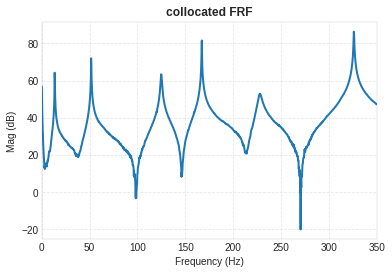

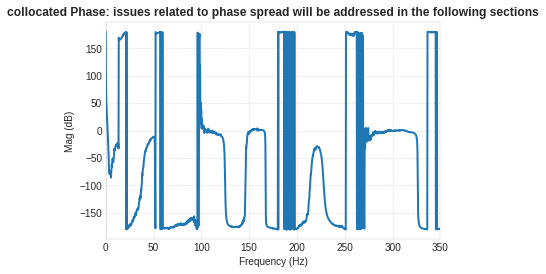

In [171]:
mat_contents=sio.loadmat('modaldata/frf1.mat')
h1 = mat_contents['frf1']
h1 = np.array(h1)
mat_contents=sio.loadmat('modaldata/freqencies.mat')
f = mat_contents['freqencies']
f = np.array(f)
fig=plt.figure()
plt.title('collocated FRF', fontweight='bold')
plt.plot(f, 20*np.log10(h1))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid(True)
plt.xlim(xmax=350, xmin=0)
plt.show()

fig=plt.figure()
plt.title('collocated Phase: issues related to phase spread will be addressed in the following sections', fontweight='bold')
plt.plot(f, np.degrees(np.angle(h1)))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid(True)
plt.xlim(xmax=350, xmin=0)
plt.show()


**Observations from the FRF and Why is it the case ?**

- At anit-resonances the phase went up and hit 180 degrees. So, at that point, the two amplitudes are same but one is out-of-phase with the other and because it is out-of-phase, they end up with a subtraction. And that is the reason there are anti-resonances before every other resonance. 


- If we excite anywhere else on the structure except the drive point then it would be sometimes in-phase and sometimes out-of-phase. However, at driving point every resonance is in-phase with each other because they are all pushed with same force in the same direction and when out-of-phase then that is the anti-resonance.


- Depending on the phase of the transducer, they can all be either down or up but will be in the same direction.


## Even Experts Have Difficulty:

**Case Study1:** 

- There was a test object that was sent to a group of Test Engineers to conduct a test to extract FRF and we can see below are the results plotted together that the spread was quite significant considering the math is still the same.

![alt](img/experts1)



**Case Study2: GARTEUR "Round Robin" Test: Level 4 DTA**

- An aeroplane like specimen was sent to many labs and they were asked to test it for natural frequency and damping. It was found that there was 30% variation in the damping ratio, 4% variation in the resonance frequency. And when they computed a mathematical model for flutter, 13% variation was observed.


- So, we can observe that it is very easy to make a mistake in the damping measurement. We have to be very careful about that.
![alt](img/Garteur1)

**Note:** Under the auspices of Group of Aeronautical Research and Technology in Europe (GARTEUR): Twelve experienced GVT units from all of Europe performed the above modal test of the same test specimen. (ref. NLR TP 97086U, 1996) 

## In Summary: Tips and Tricks for best results:



- **Verify measurement chain integrity prior to test:**
  1. Transducer calibration
  2. Mass Ratio calibration


- **Verify suitability of input and output transducers:**
  1. Operating ranges(frequency, dynamic range, phase response)
  2. Mass loading
  3. Mounting
  4. Sensitivity to environmental effects
  5. Stability


- **Verify suitability of test set-up:**
  1. Transducer positioning and alignment 
  2. Pre-test: rattling, boundary conditions, rigid body modes, signal-to-noise ratio, linear approximation, excitation   signal, repeated roots, maxwell reciprocity, force measurement, exciter-input transducer-stringer-structure connection


- **Remember:**
  1. Quality FRF measurements are the foundation of experimental modal analysis
  

- **Select the Proper Resolution:**
  1. High resolution = Longer time block
  2. When hammer testing time block is critical!
 

- **Use the Right Window:**
  1. Hammer Testing: Uniform or Transient/Exponential Window
  2. Shaker Testing: Uniform or Hanning based in excitation
  3. Apply decay correction on Exponential window
  

- **Pay Attention to Coherence:**
  1. The higher the better
  2. If we have poor coherence, retest the point
  

- **Keep track of the DOFs:**
  1. Each measurement is a Degree of Freedom
  2. Direction and location information is critical

## Actual Testing and Analysis:

### Determining the number of points to use on the structure:




- Building an FE model would be a good way to start with as the FEA can help us to determine the number of points to mathematically separate all modes.


- So, at first creating a beam model by choosing number of nodes and elements that would represent the number of modes of interest. If we look at the results there is this third dynamic mode which will not be seen in the experimental results as sensor is uniaxial, so we neglect it when we calculate MAC later.


- In real world, the tests are done in free-free conditions and in that case, if we look at the FE model results then we would see number of rigid body motions but they are all of no interest, only dynamic flexible modes that deform are more important.


- If we see below, we can see 18 points are enough to be able to map all six mode shapes that we are interested in.



#### Demonstration of how the reduced K and M matrix (using Guyan) pulled out from the Beam model to find out the mode shapes:

In [176]:
%matplotlib inline
mat_contents=sio.loadmat('FEmodaldata/WingBeamforMAC.mat')
K = (mat_contents['Kr'])
M = (mat_contents['Mr'])
Kbm = K.todense()
Mbm = M.todense()
omega, zeta, PsiBM = vt.sos_modal(Mbm, Kbm)
Psi_1 = PsiBM
mode1=Psi_1[:,0]
mode2=Psi_1[:,1]
mode3=Psi_1[:,3]
mode4=Psi_1[:,4]
mode5=Psi_1[:,5]
mode6=Psi_1[:,6]
Psi_2BM= np.column_stack((mode1, mode2, mode3, mode4, mode5, mode6))
omegaBM = [omega[0],omega[1],omega[2],omega[3],omega[4],omega[6]]
omegaBM

[11.214728919133529,
 48.724845725614983,
 94.961906540415697,
 119.36969102607624,
 202.28950337721446,
 320.77102270414338]


![alt](img/Beammodelmode1.jpg)  ![alt](img/Beammodelmode2.jpg)  ![alt](img/Beammodelmodeextra.jpg)  
![alt](img/Beammodelmode3.jpg)  ![alt](img/Beammodelmode4.jpg)  ![alt](img/Beammodelmode5.jpg)  
![alt](img/Beammodelmode6.jpg)

 ### Creating the Geometry of the wing using OpenModal:

The geometry does not need to be a precise reproduction of the DUT. The geometry is only needed for the visualization of the mode shape. 

So, we don't  need to have the geometry that represent the wing exactly. An open source experimental modal analysis software called "OpenModal" was used to create a 18 consistent points joined by lines and surfaces to roughly represent the top view of the wing structure. 
 

 
 ![alt](img/wingmodel)

### DOF setup for the roving impact method: (SISO)

With the Roving Hammer excitation the one reference Accelerometer was kept at a fixed location 1 and the hammer is used to impact at all the DOF identified in the the negative z direction. All those FRF will be used for the modal analysis post- process calculation.

#### Quality of the data check: done of all the FRFs, here demonstrating only one:

This is like a repeat, this has already been demonstrated in the pre-test above. Basically, the pre-test allows to try different excitation scenario and pick the best. The softer tip was not an appropriate since it drops before 200 Hz and so the coherence was poor starting at 250 Hz. The hard tip tends to agree well. And that is demonstrated below:

/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0, 350)

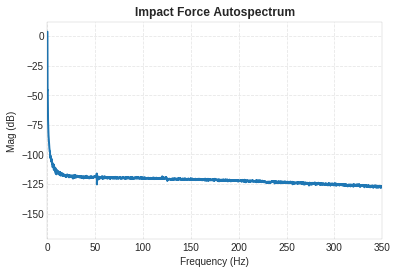

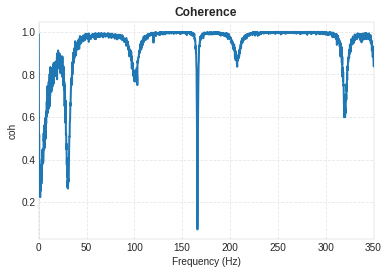

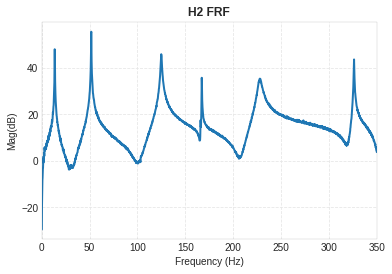

In [178]:
%matplotlib inline
mat_contents=sio.loadmat('modaldata/rawdata_1.mat')
Time_data= mat_contents['Time_domain']
Time_data= np.array(Time_data)
Time_data= np.transpose(Time_data)
rawimpact1 = mat_contents['Time_chan_1']
rawimpact1 = np.array(rawimpact1)
rawresponse1= mat_contents['Time_chan_2']
rawresponse1 = np.array(rawresponse1)
mat_contents=sio.loadmat('modaldata/rawdata_2.mat')
rawimpact2 = mat_contents['Time_chan_1']
rawimpact2 = np.array(rawimpact2)
rawresponse2= mat_contents['Time_chan_2']
rawresponse2 = np.array(rawresponse2)
mat_contents=sio.loadmat('modaldata/rawdata_3.mat')
rawimpact3 = mat_contents['Time_chan_1']
rawimpact3 = np.array(rawimpact3)
rawresponse3= mat_contents['Time_chan_2']
rawresponse3 = np.array(rawresponse3)

x= np.column_stack((rawresponse1,rawresponse2,rawresponse3))
x=np.array([x]).reshape(1,16384,3)

f= np.column_stack((rawimpact1,rawimpact2,rawimpact3))
f=np.array([f]).reshape(1,16384,3)

[freq,Pxx]=vt.asd(x,Time_data,windowname="none")

[freq,Pff]=vt.asd(f,Time_data,windowname="none")

[freq,Pxf]=vt.crsd(f,x,Time_data,windowname="none")

freq=np.array([freq]).reshape(1,8193)


fig=plt.figure()
plt.title('Impact Force Autospectrum', fontweight='bold')
plt.plot(freq.T, 20*np.log10((Pff)).T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid(True)
plt.xlim(xmax=350, xmin=0)

H1=np.conj(Pxf/Pff)
H2=Pxx/Pxf
coh=(Pxf*np.conj(Pxf)).real/Pxx/Pff

fig=plt.figure()
plt.title('Coherence', fontweight='bold')
plt.plot(freq.T, coh.T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('coh')
plt.grid(True)
plt.xlim(xmax=350, xmin=0)

fig=plt.figure()
plt.title('H2 FRF', fontweight='bold')
plt.plot(freq.T, 20*np.log10((H2)).T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag(dB)')
plt.grid(True)
plt.xlim(xmax=350, xmin=0)


### DOF setup for the Fixed shaker method: 

With the Shaker excitation, typically one or more shakers are fixed at well selected locations after pretesting with hammer to make sure that location is not a node at any natural frequencies that we are measuring and one or several accelerometers can be roved along all the DOF on the wing during the measurement sequence. 

With enough hardware all the DOF could be acquired in one measurement.

#### Quality of the data check: done of all the FRFs, here demonstrating only one:

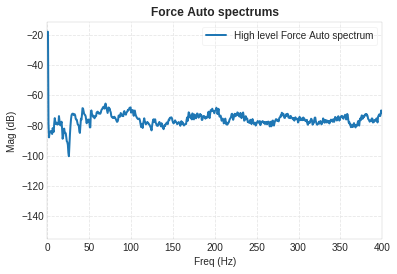

/home/sainag/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


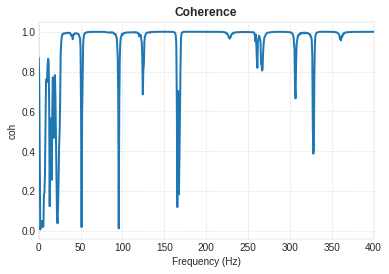

/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


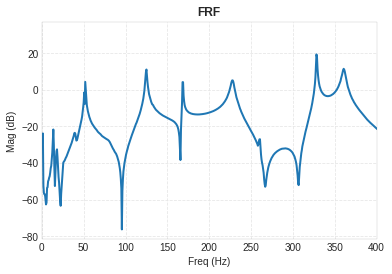

In [180]:
%matplotlib inline
mat_contents=sio.loadmat('linearitycheck/high.mat')
Frequency= mat_contents['Freq_domain']
Frequency= np.array(Frequency)
Highresponse = mat_contents['Hf_chan_2']
Highresponse = np.array(Highresponse)
PSDHighresponse = mat_contents['PSD_chan_2']
PSDHighresponse = np.array(PSDHighresponse)
PSDHighLevelRandom = mat_contents['PSD_chan_1']
PSDHighLevelRandom = np.array(PSDHighLevelRandom)
coh = mat_contents['Hf_coh_chan_2']
Highcoh = np.array(coh)



fig=plt.figure()
plt.title('Force Auto spectrums', fontweight='bold')

plt.plot(Frequency, 20*np.log10(PSDHighLevelRandom), label= 'High level Force Auto spectrum')

plt.xlabel('Freq (Hz)')
plt.ylabel('Mag (dB)')
plt.xlim(xmax=400, xmin=0)
plt.grid(True)
plt.legend()
plt.show()

fig=plt.figure()
plt.title('Coherence', fontweight='bold')

plt.plot(Frequency, Highcoh)
plt.xlim(xmax=400, xmin=0)
plt.xlabel('Frequency (Hz)')
plt.ylabel('coh')
plt.grid(True)
plt.legend()
plt.show()


fig=plt.figure()
plt.title('FRF', fontweight='bold')


plt.plot(Frequency, 20*np.log10(Highresponse))

plt.xlabel('Freq (Hz)')
plt.ylabel('Mag (dB)')
plt.xlim(xmax=400, xmin=0)
plt.grid(True)
plt.legend()
plt.show()




**Observations:** 

- FRFs look rugged and at the low frequencies the coherence is not good. Therefore, impact results look much better than the random excitation results for the frequency range of interest from 0-350Hz. 

#### Data collected from impact test:

In [181]:
mat_contents=sio.loadmat('modaldata/frf1.mat')
h1 = mat_contents['frf1']
h1 = np.array(h1)
mat_contents=sio.loadmat('modaldata/frf2.mat')
h2 = mat_contents['frf2']
h2 = np.array(h2)
mat_contents=sio.loadmat('modaldata/frf3.mat')
h3 = mat_contents['frf3']
h3 = np.array(h3)
mat_contents=sio.loadmat('modaldata/frf4.mat')
h4 = mat_contents['frf4']
h4 = np.array(h4)
mat_contents=sio.loadmat('modaldata/frf5.mat')
h5 = mat_contents['frf5']
h5 = np.array(h5)
mat_contents=sio.loadmat('modaldata/frf6.mat')
h6 = mat_contents['frf6']
h6 = np.array(h6)
mat_contents=sio.loadmat('modaldata/frf7.mat')
h7 = mat_contents['frf7']
h7 = np.array(h7)
mat_contents=sio.loadmat('modaldata/frf8.mat')
h8 = mat_contents['frf8']
h8 = np.array(h8)
mat_contents=sio.loadmat('modaldata/frf9.mat')
h9 = mat_contents['frf9']
h9 = np.array(h9)
mat_contents=sio.loadmat('modaldata/frf10.mat')
h10 = mat_contents['frf10']
h10 = np.array(h10)
mat_contents=sio.loadmat('modaldata/frf11.mat')
h11 = mat_contents['frf11']
h11 = np.array(h11)
mat_contents=sio.loadmat('modaldata/frf12.mat')
h12 = mat_contents['frf12']
h12 = np.array(h12)
mat_contents=sio.loadmat('modaldata/frf13.mat')
h13 = mat_contents['frf13']
h13 = np.array(h13)
mat_contents=sio.loadmat('modaldata/frf14.mat')
h14 = mat_contents['frf14']
h14 = np.array(h14)
mat_contents=sio.loadmat('modaldata/frf15.mat')
h15 = mat_contents['frf15']
h15 = np.array(h15)
mat_contents=sio.loadmat('modaldata/frf16.mat')
h16 = mat_contents['frf16']
h16 = np.array(h16)
mat_contents=sio.loadmat('modaldata/frf17.mat')
h17 = mat_contents['frf17']
h17 = np.array(h17)
mat_contents=sio.loadmat('modaldata/frf18.mat')
h18 = mat_contents['frf18']
h18 = np.array(h18)
mat_contents=sio.loadmat('modaldata/freqencies.mat')
f = mat_contents['freqencies']
f = np.array(f)

In [182]:
mat_contents=sio.loadmat('UsingShaker/1.mat')
response1 = mat_contents['Hf_chan_2']
response1 = np.array(response1)
mat_contents=sio.loadmat('UsingShaker/2.mat')
response2 = mat_contents['Hf_chan_2']
response2 = np.array(response2)
mat_contents=sio.loadmat('UsingShaker/3.mat')
response3 = mat_contents['Hf_chan_2']
response3 = np.array(response3)
mat_contents=sio.loadmat('UsingShaker/4.mat')
response4 = mat_contents['Hf_chan_2']
response4 = np.array(response4)
mat_contents=sio.loadmat('UsingShaker/5.mat')
response5 = mat_contents['Hf_chan_2']
response5 = np.array(response5)
mat_contents=sio.loadmat('UsingShaker/6.mat')
response6 = mat_contents['Hf_chan_2']
response6 = np.array(response6)
mat_contents=sio.loadmat('UsingShaker/7.mat')
response7 = mat_contents['Hf_chan_2']
response7 = np.array(response7)
mat_contents=sio.loadmat('UsingShaker/8.mat')
response8 = mat_contents['Hf_chan_2']
response8 = np.array(response8)
mat_contents=sio.loadmat('UsingShaker/9.mat')
response9 = mat_contents['Hf_chan_2']
response9 = np.array(response9)
mat_contents=sio.loadmat('UsingShaker/10.mat')
response10 = mat_contents['Hf_chan_2']
response10 = np.array(response10)
mat_contents=sio.loadmat('UsingShaker/10.mat')
response11 = mat_contents['Hf_chan_2']
response11 = np.array(response11)
mat_contents=sio.loadmat('UsingShaker/12.mat')
response12 = mat_contents['Hf_chan_2']
response12 = np.array(response12)
mat_contents=sio.loadmat('UsingShaker/13.mat')
response13 = mat_contents['Hf_chan_2']
response13 = np.array(response13)
mat_contents=sio.loadmat('UsingShaker/14.mat')
response14 = mat_contents['Hf_chan_2']
response14 = np.array(response14)
mat_contents=sio.loadmat('UsingShaker/15.mat')
response15 = mat_contents['Hf_chan_2']
response15 = np.array(response15)
mat_contents=sio.loadmat('UsingShaker/16.mat')
response16 = mat_contents['Hf_chan_2']
response16 = np.array(response16)
mat_contents=sio.loadmat('UsingShaker/17.mat')
response17 = mat_contents['Hf_chan_2']
response17 = np.array(response17)
mat_contents=sio.loadmat('UsingShaker/18.mat')
response18 = mat_contents['Hf_chan_2']
response18 = np.array(response18)

Frequency= mat_contents['Freq_domain']

f1 = np.array(Frequency)

### Measurement Validation: done with OpenModal Gui:


- **Animate the data via the "Function Animation":** Here, the cursor just looks at amplitude and phase at every location and plot them using the raw data. So, using raw data, we can click in between two resonance and have the linear combination of the two, it makes more sense when we take the cursor to the peaks. Function animation is also called as method of animating mode shapes by "Peak Picking".


- These mode shapes can be compared later with the original mode shapes obtained from curve fitting. 


 ![alt](img/11)  ![alt](img/12)  ![alt](img/13)  ![alt](img/14)  ![alt](img/15)  ![alt](img/16)

**Important Note:** - Since the resonances of interest from 0 to 350 Hz are nice and clean, the method of peak picking holds good. However, one has to keep in mind that not every structure is like that, in fact, most structures don't behave like the case here. So, we use suitable way to curve fit.

## Curve Fitting

- In early days, the curve fit was done only for one resonance and one measurement at a time, it would take long time for the analysis. Today, curve fitters are Multiple degree of freedom curve fitters which curve fit multiple resonances all at once, that is better because it takes into account the influence of one on the other and in our case we still have extremely easy data set because every peak is well separated. However, in some FRF, it is difficult to determine what is happening. So, they need to be able to curve fit multiple resonances at a time and it is global because it does every measurement together.


- Now, we have FRFs and to be able to create our mathematical model and decompose this MDOF system in individual SDOF systems through the curve fitting. The goal is to measure sufficiently large number of points on the structure to be able to characterize the Mode shapes, each resonance has it's own unique mode shape. . 

**Rule of which curve fitter to use:** There are no rules, curve fitting, as much science as it is an art. We need to learn, experiment to see which one does the better job for the given conditions, so there no fixed rules.

### Curve Fitting Techniques:



**Single Degree of Freedom (SDOF)**


- **SDOF Polynomial**


- Circle Fit


**Multi Degree of Freedom (MDOF)**


- **MDOF Polynomial**


- **Complex Exponential**


- Direct Parameter


- Polyreference


- ...................
 
 

## MDOF_CF Curve Fitter in Vibration Testing Tool box:



**Note from the Author of the curve fitter:** FRF are columns comprised of the FRFs presuming single input, multiple output z and nf are the damping ratio and natural frequency (Hz) u is the mode shape. Only one peak may exist in the segment of the FRF passed to sdofcf. No zeros may exist within this segment. If so, curve fitting becomes unreliable.

This curvefit has to be validated using the Sdofcf later to visualize for the best possible fit

In [185]:

TF= np.column_stack((h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12,h13,h14,h15,h16,h17,h18))
[Damping1,naturalfreq1,U1]=vt.mdof_cf(f,TF,40,70)
[Damping2,naturalfreq2,U2]=vt.mdof_cf(f,TF,165,255)
[Damping3,naturalfreq3,U3]=vt.mdof_cf(f,TF,470,560)
[Damping4,naturalfreq4,U4]=vt.mdof_cf(f,TF,640,730)
[Damping5,naturalfreq5,U5]=vt.mdof_cf(f,TF,890,980)
[Damping6,naturalfreq6,U6]=vt.mdof_cf(f,TF,1290,1390)
Damping = Damping1, Damping2, Damping3, Damping4, Damping5, Damping6
Naturalfreq = naturalfreq1, naturalfreq2, naturalfreq3, naturalfreq4, naturalfreq5, naturalfreq6
Psi_1 = np.array(U1)
Psi_2 = np.array(U2)
Psi_3 = np.array(U3)
Psi_4 = np.array(U4)
Psi_5 = np.array(U5)
Psi_6 = np.array(U6)
Psi_1=np.column_stack((Psi_1,Psi_2,Psi_3,Psi_4,Psi_5,Psi_6))
Psi_abs = np.abs(Psi_1)*np.real(np.sign(Psi_1))
Psi_1 = Psi_abs

### Validation of MDOF curve fitting using SDOF Polynomial Curve Fitter:



This is important to check whether the bounds set for the MDOF_CF gives the best curve fit by satifying all the rules, this is only possible by visualizing each degree of freedom curve fit making sure that there is no anti-resonance or zeros within the bound set. It is a slow process and another compromise for good results.



#### Visually validating the curve fit  for first six modes of the FRF at point 1:

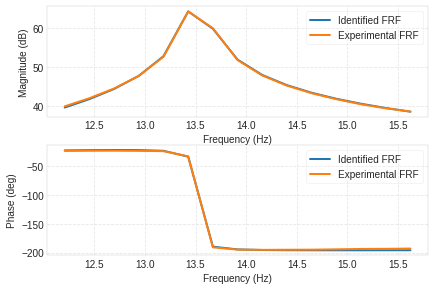

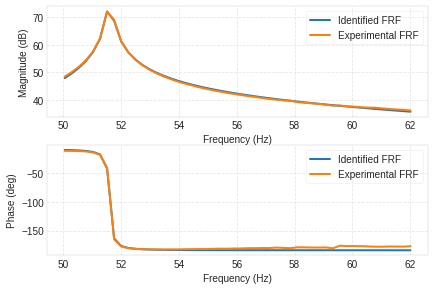

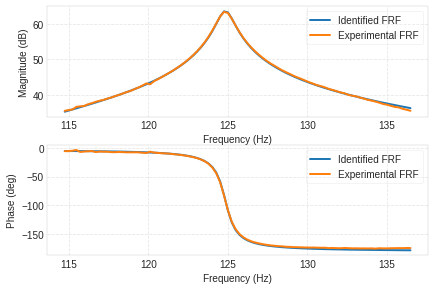

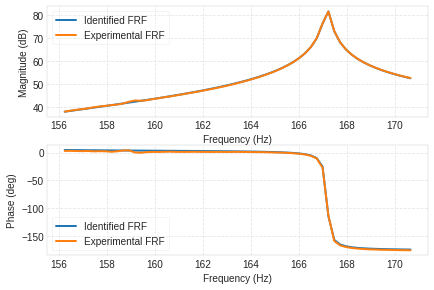

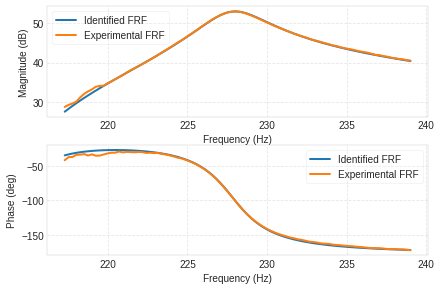

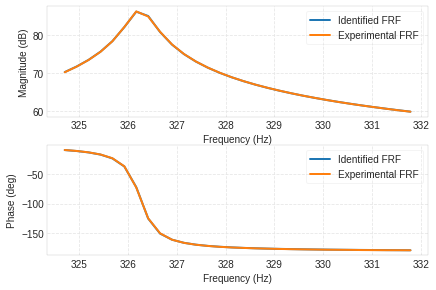

In [107]:
%matplotlib inline
vt.sdof_cf(f,h1,50,65)
vt.sdof_cf(f,h1,205,255)
vt.sdof_cf(f,h1,470,560)
vt.sdof_cf(f,h1,640,700)
vt.sdof_cf(f,h1,890,980)
vt.sdof_cf(f,h1,1330,1360)
plt.show()

**Observation:** 

- Curve fit looks normal for all the modes.


#### Visually validating FRF at point 2:

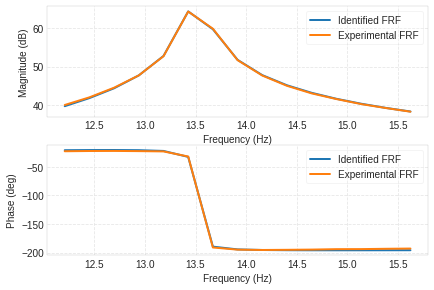

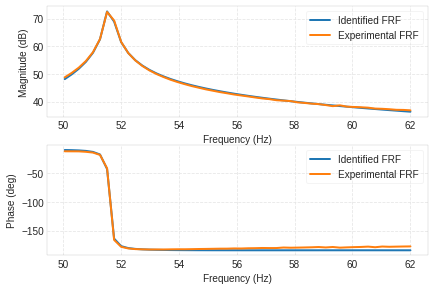

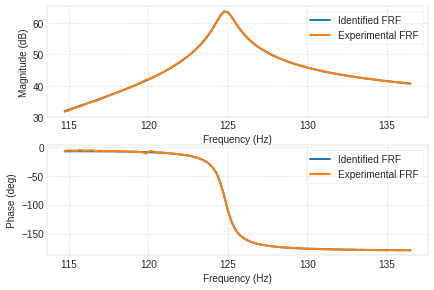

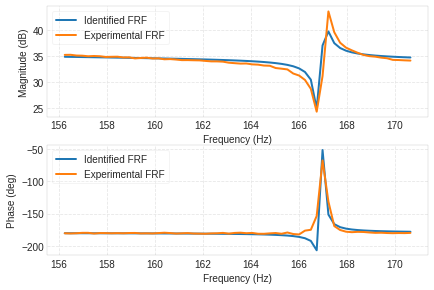

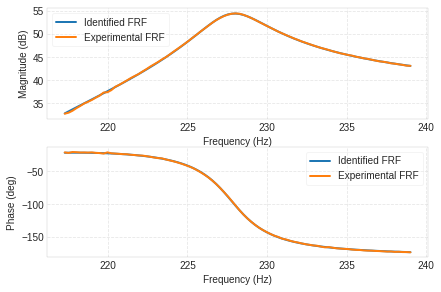

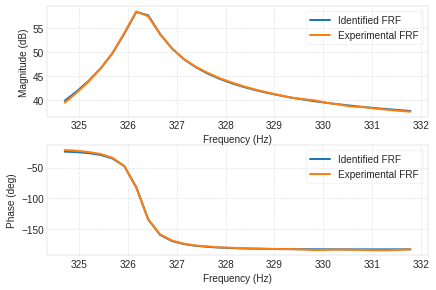

In [108]:
%matplotlib inline
vt.sdof_cf(f,h2,50,65)
vt.sdof_cf(f,h2,205,255)
vt.sdof_cf(f,h2,470,560)
vt.sdof_cf(f,h2,640,700)
vt.sdof_cf(f,h2,890,980)
vt.sdof_cf(f,h2,1330,1360)
plt.show()

**Observations:**

- Curve fit for mode 4 looks bad but still the bounds are not adjusted because there is no Mode 4 at point 2 as it would not move in torsion. So, it's a node. Ajusting it to fit well and using that value for other FRFs may not be reliable. Hence, no changes were made to adjust curve fit.


- Mode 6 bound had anti-resonance, and the curve fit looked unreliable. So, it is corrected by changing the min limit from 1290 to 1330. This is also corrected for rest of the FRFs.

#### Visually validating FRF at point 3:

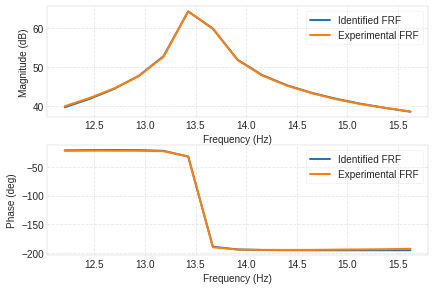

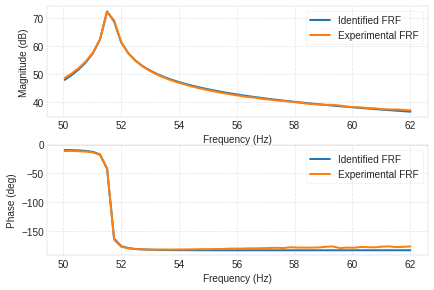

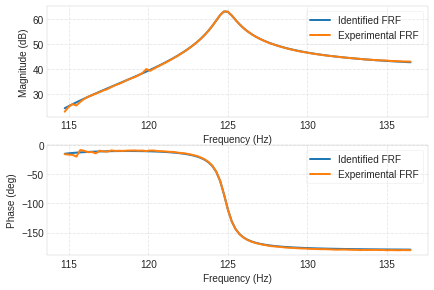

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


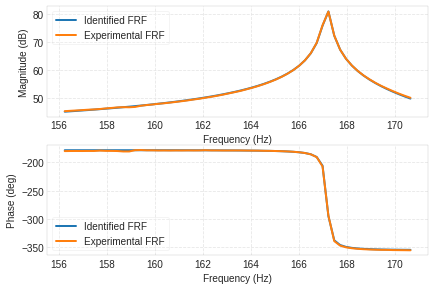

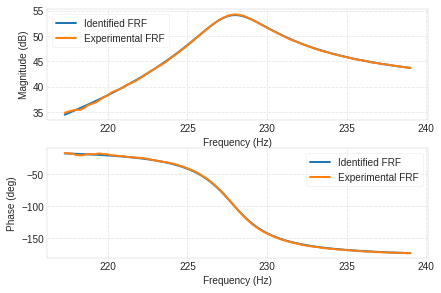

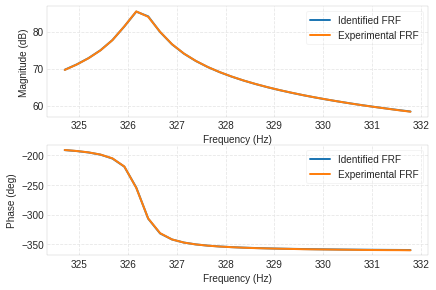

In [109]:
%matplotlib inline
vt.sdof_cf(f,h3,50,65)
vt.sdof_cf(f,h3,205,255)
vt.sdof_cf(f,h3,470,560)
vt.sdof_cf(f,h3,640,700)
vt.sdof_cf(f,h3,890,980)
vt.sdof_cf(f,h3,1330,1360)
plt.show()

**Observation**

- All the modes are very well curve fitted.

#### Visually validating FRF at point 4:

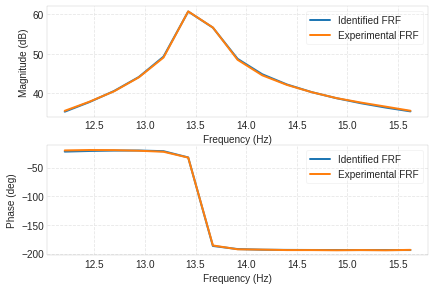

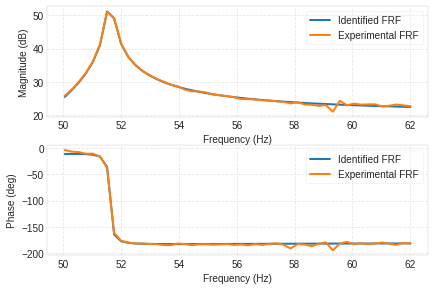

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


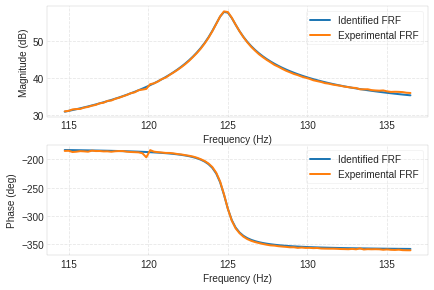

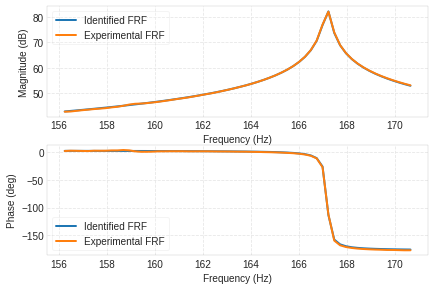

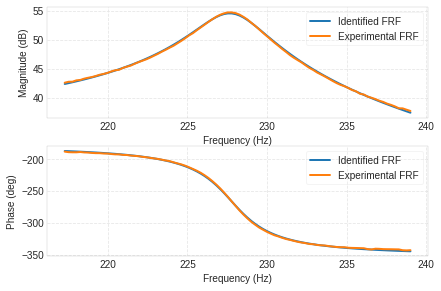

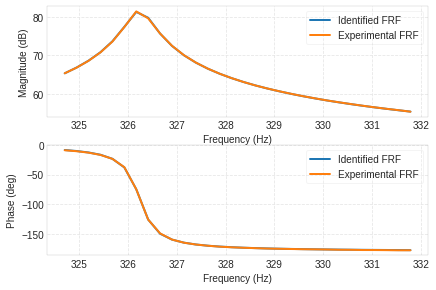

In [110]:
%matplotlib inline
vt.sdof_cf(f,h4,50,65)
vt.sdof_cf(f,h4,205,255)
vt.sdof_cf(f,h4,470,560)
vt.sdof_cf(f,h4,640,700)
vt.sdof_cf(f,h4,890,980)
vt.sdof_cf(f,h4,1330,1360)
plt.show()

**Observations:**

- Mode 1 bound had anti-resonance, and the curve fit looked unreliable. So, it is corrected by changing the min limit from 165 to 205. This is also corrected for rest of the FRFs.

#### Visually validating FRF at point 5:

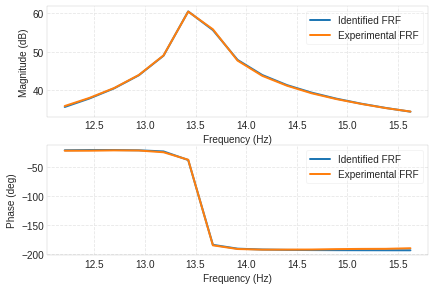

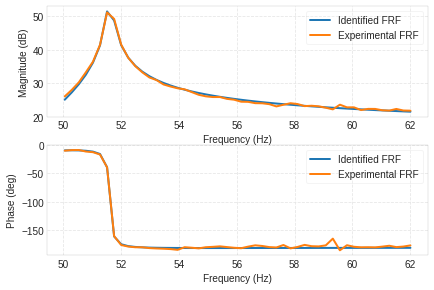

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


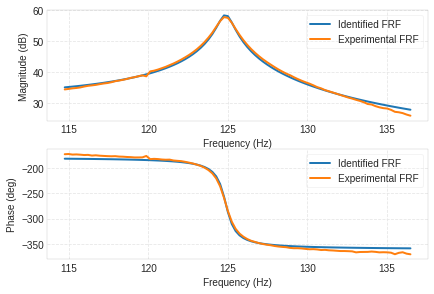

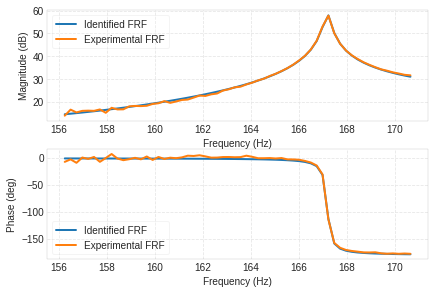

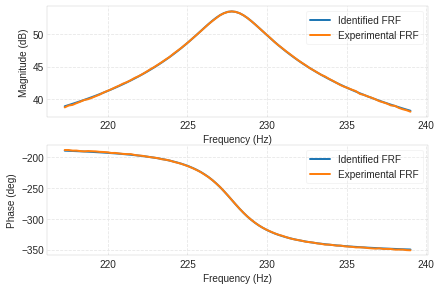

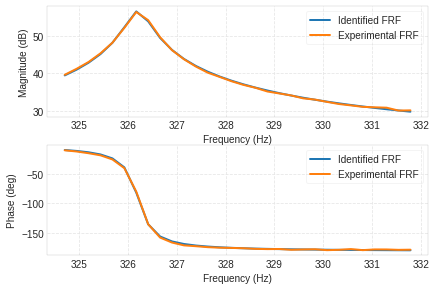

In [111]:
%matplotlib inline
vt.sdof_cf(f,h5,50,65)
vt.sdof_cf(f,h5,205,255)
vt.sdof_cf(f,h5,470,560)
vt.sdof_cf(f,h5,640,700)
vt.sdof_cf(f,h5,890,980)
vt.sdof_cf(f,h5,1330,1360)
plt.show()

**Observations:**

- Curve fit looks fine.

#### Visually validating FRF at point 6:

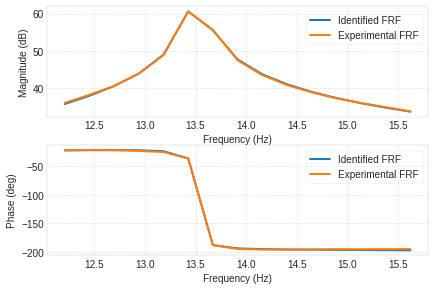

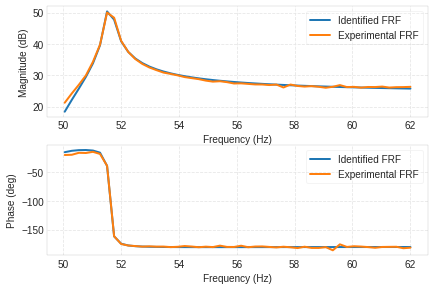

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


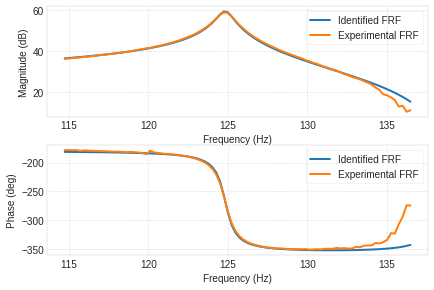

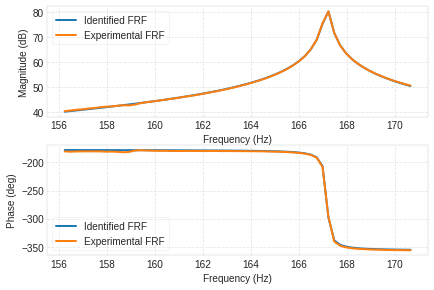

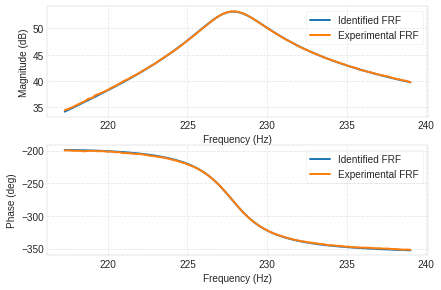

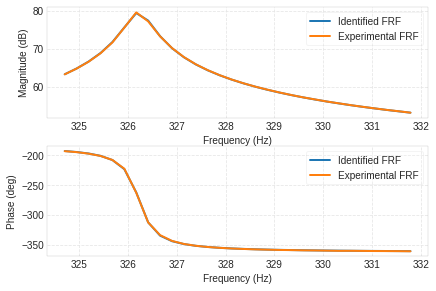

In [112]:
%matplotlib inline
vt.sdof_cf(f,h6,50,65)
vt.sdof_cf(f,h6,205,255)
vt.sdof_cf(f,h6,470,560)
vt.sdof_cf(f,h6,640,700)
vt.sdof_cf(f,h6,890,980)
vt.sdof_cf(f,h6,1330,1360)
plt.show()

**Observations:**

- Curve fit looks fine.

#### Visually validating FRF at point 7:

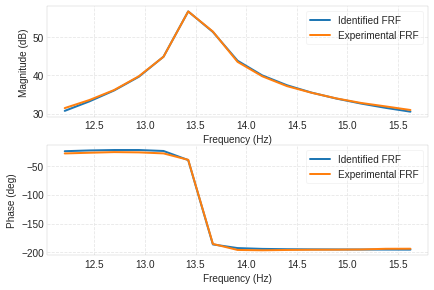

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


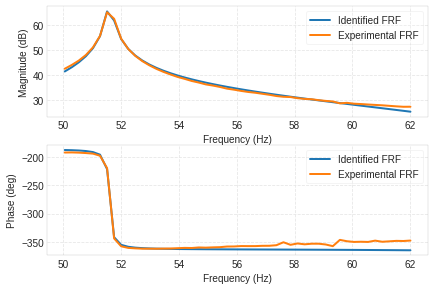

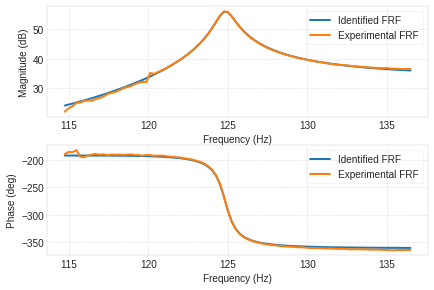

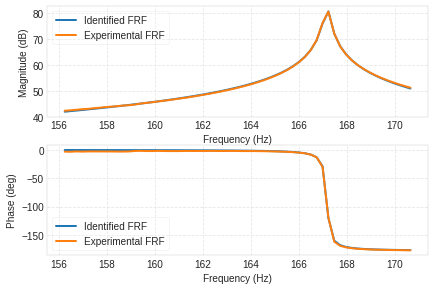

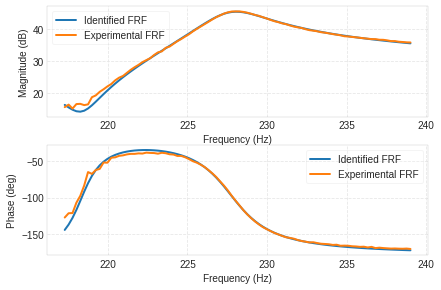

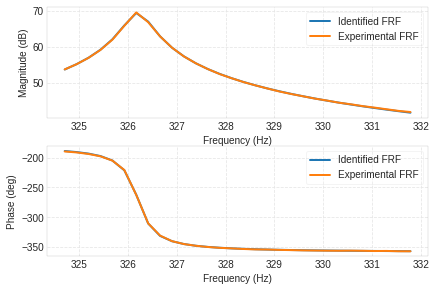

In [113]:
%matplotlib inline
vt.sdof_cf(f,h7,50,65)
vt.sdof_cf(f,h7,205,255)
vt.sdof_cf(f,h7,470,560)
vt.sdof_cf(f,h7,640,700)
vt.sdof_cf(f,h7,890,980)
vt.sdof_cf(f,h7,1330,1360)
plt.show()

**Observations:**

- Curve fit looks fine.

#### Visually validating FRF at point 8:

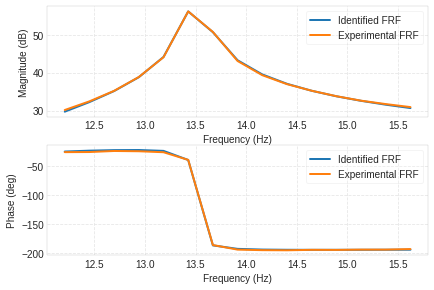

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


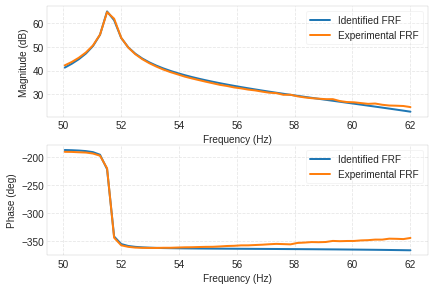

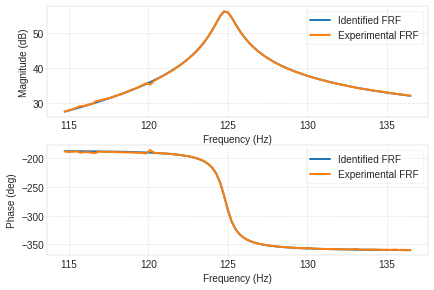

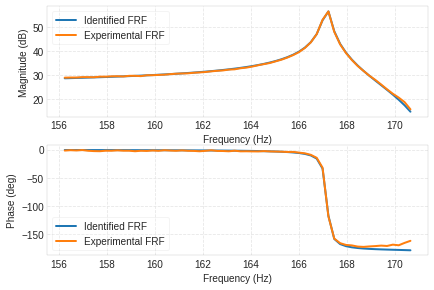

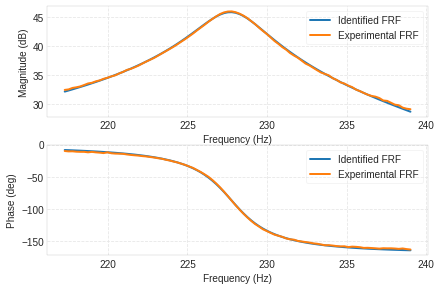

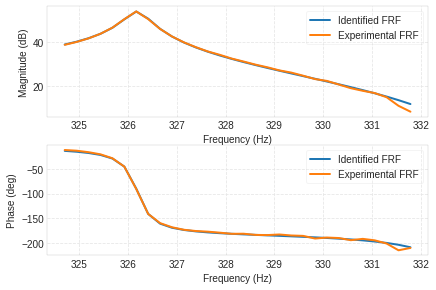

In [114]:
%matplotlib inline
vt.sdof_cf(f,h8,50,65)
vt.sdof_cf(f,h8,205,255)
vt.sdof_cf(f,h8,470,560)
vt.sdof_cf(f,h8,640,700)
vt.sdof_cf(f,h8,890,980)
vt.sdof_cf(f,h8,1330,1360)
plt.show()

**Observations:**

- Mode 6 bound had anti-resonance, and the curve fit looked unreliable. So, it is corrected by changing the max limit from 1390 to 1360. This is also corrected for rest of the FRFs.


- Mode 4 bound had anti-resonance, and the curve fit looked unreliable. So, it is corrected by changing the max limit from 730 to 700. This is also corrected for rest of the FRFs.

#### Visually validating FRF at point 9:

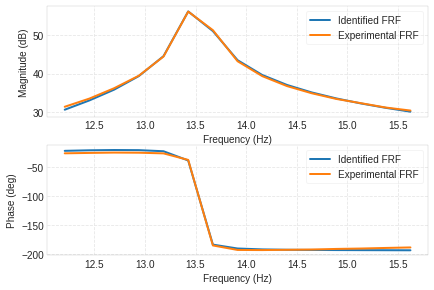

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


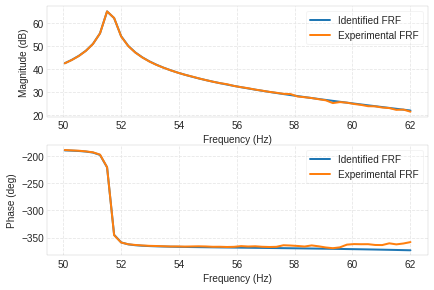

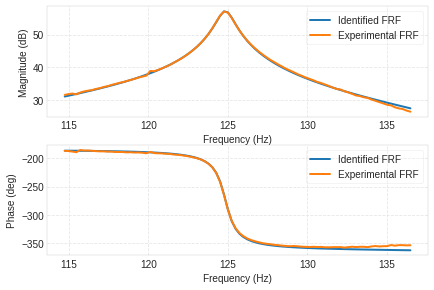

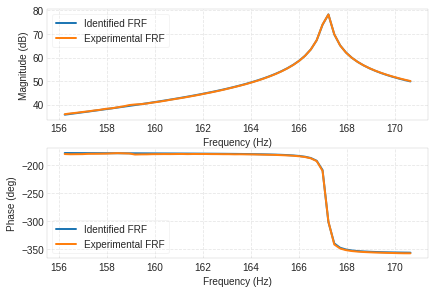

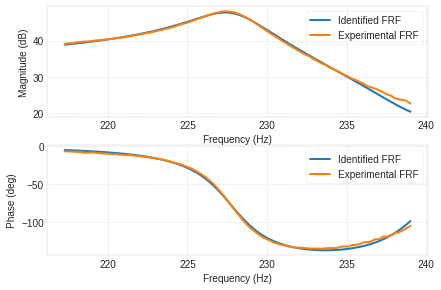

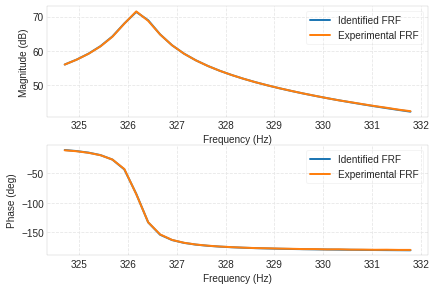

In [115]:
%matplotlib inline
vt.sdof_cf(f,h9,50,65)
vt.sdof_cf(f,h9,205,255)
vt.sdof_cf(f,h9,470,560)
vt.sdof_cf(f,h9,640,700)
vt.sdof_cf(f,h9,890,980)
vt.sdof_cf(f,h9,1330,1360)
plt.show()

**Observations:**

- Curve fit looks fine.

#### Visually validating FRF at point 10:

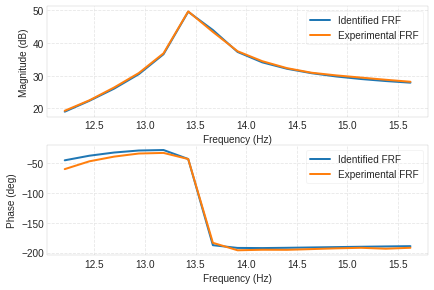

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


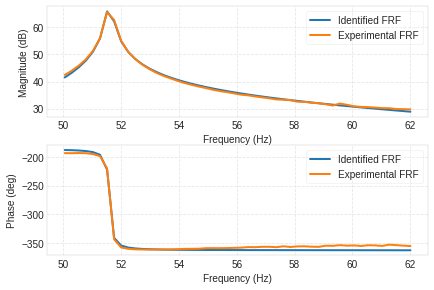

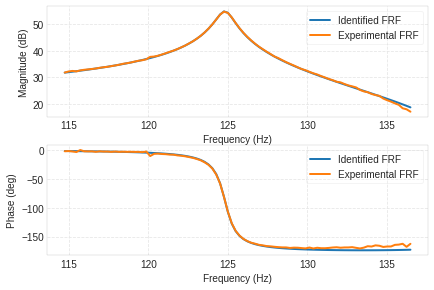

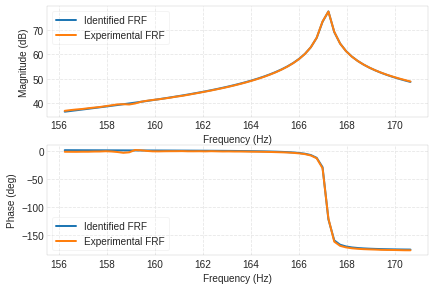

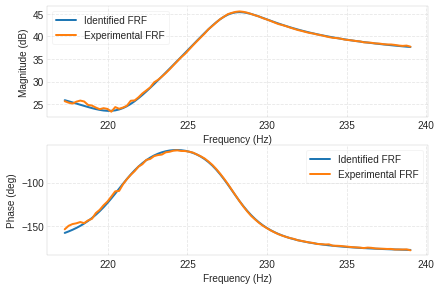

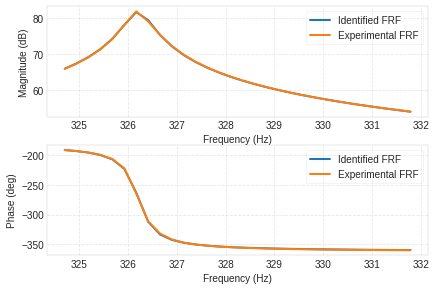

In [116]:
%matplotlib inline
vt.sdof_cf(f,h10,50,65)
vt.sdof_cf(f,h10,205,255)
vt.sdof_cf(f,h10,470,560)
vt.sdof_cf(f,h10,640,700)
vt.sdof_cf(f,h10,890,980)
vt.sdof_cf(f,h10,1330,1360)
plt.show()

**Observations:**

- Curve fit looks fine.

#### Visually validating FRF at point 11:

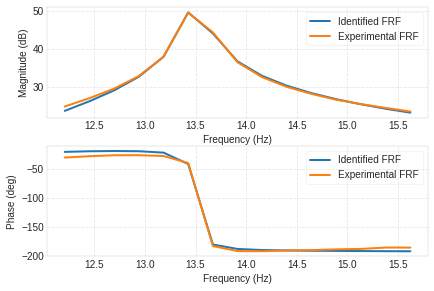

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


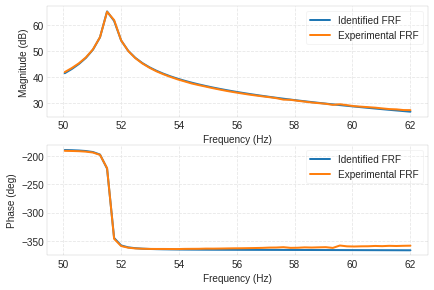

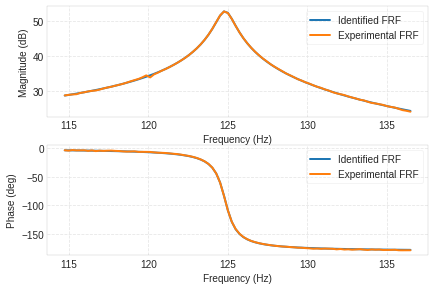

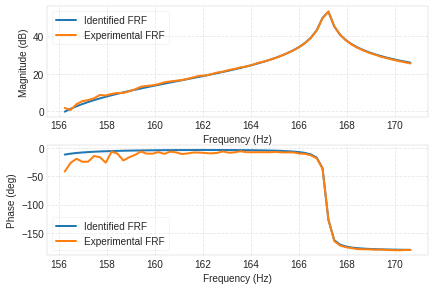

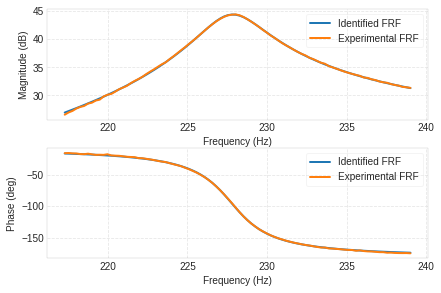

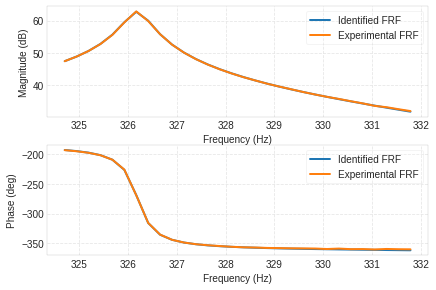

In [117]:
%matplotlib inline
vt.sdof_cf(f,h11,50,65)
vt.sdof_cf(f,h11,205,255)
vt.sdof_cf(f,h11,470,560)
vt.sdof_cf(f,h11,640,700)
vt.sdof_cf(f,h11,890,980)
vt.sdof_cf(f,h11,1330,1360)
plt.show()

**Observations:**

- Curve fit looks fine.

#### Visually validating FRF at point 12:

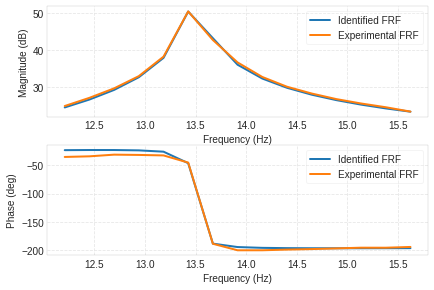

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


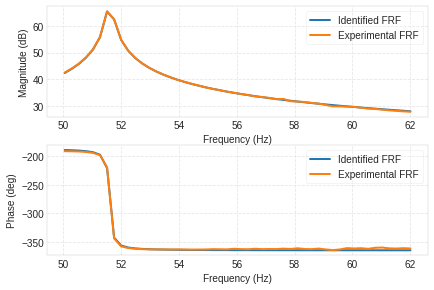

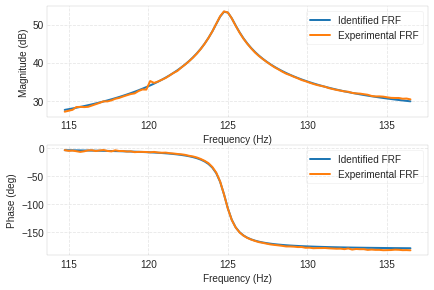

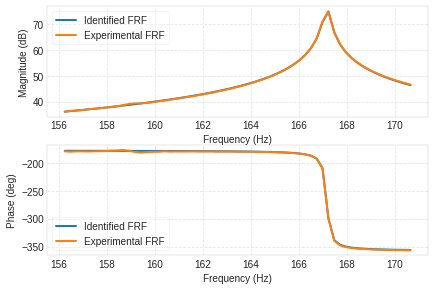

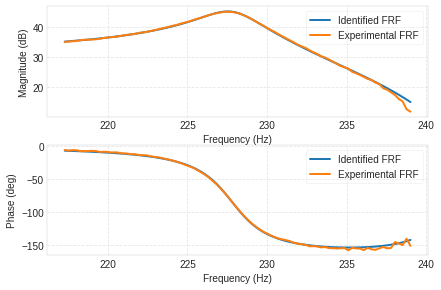

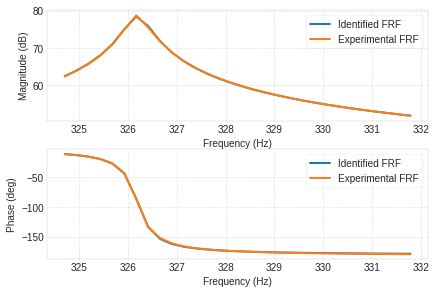

In [118]:
%matplotlib inline
vt.sdof_cf(f,h12,50,65)
vt.sdof_cf(f,h12,205,255)
vt.sdof_cf(f,h12,470,560)
vt.sdof_cf(f,h12,640,700)
vt.sdof_cf(f,h12,890,980)
vt.sdof_cf(f,h12,1330,1360)
plt.show()

**Observations:**

- Curve fit looks fine.

#### Visually validating FRF at point 13:

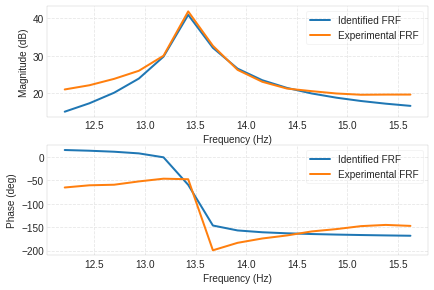

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


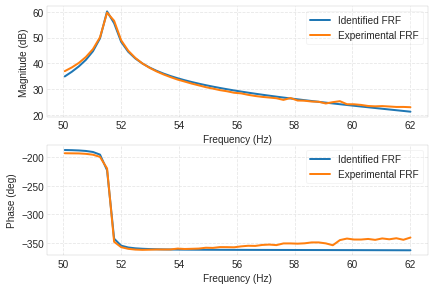

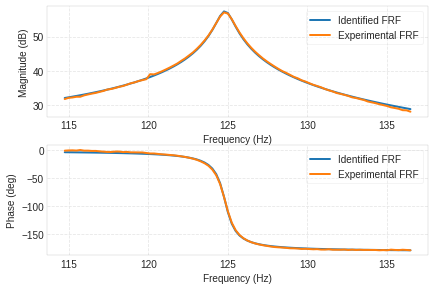

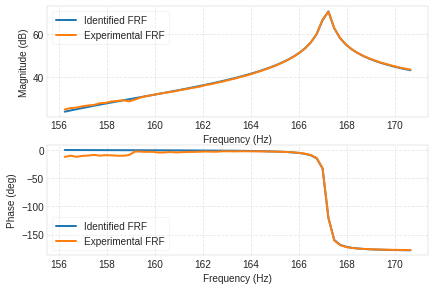

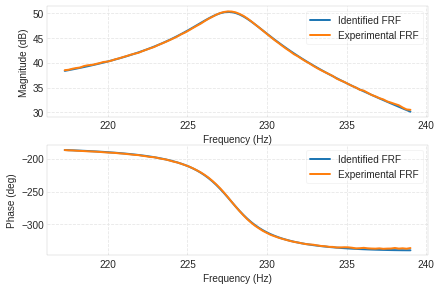

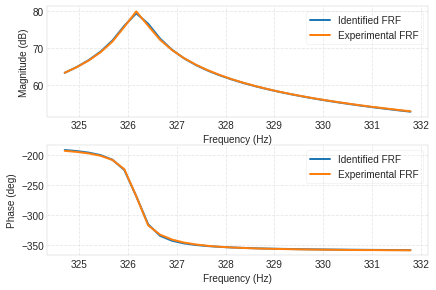

In [119]:
%matplotlib inline
vt.sdof_cf(f,h13,50,65)
vt.sdof_cf(f,h13,205,255)
vt.sdof_cf(f,h13,470,560)
vt.sdof_cf(f,h13,640,700)
vt.sdof_cf(f,h13,890,980)
vt.sdof_cf(f,h13,1330,1360)
plt.show()

**Observations:**

- Mode 1 bound had anti-resonance, and the curve fit looked unreliable. So, it is corrected and made look better by changing the max limit and min limit from 70 to 65 and 40 to 50. This is also corrected for rest of the FRFs.

#### Visually validating FRF at point 14:

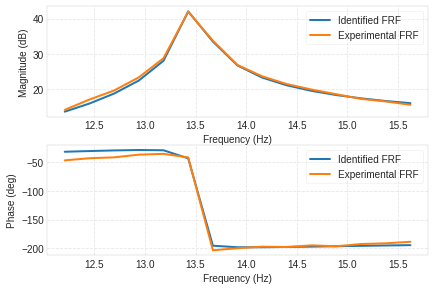

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


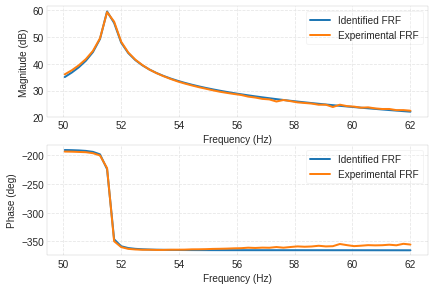

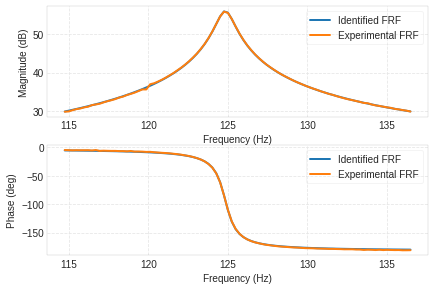

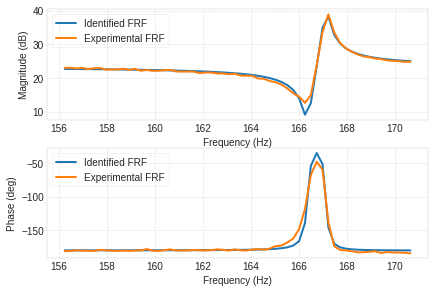

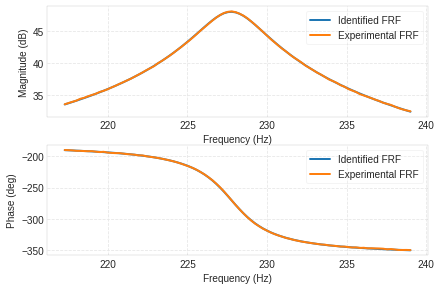

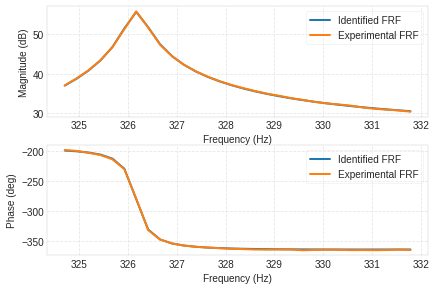

In [120]:
%matplotlib inline
vt.sdof_cf(f,h14,50,65)
vt.sdof_cf(f,h14,205,255)
vt.sdof_cf(f,h14,470,560)
vt.sdof_cf(f,h14,640,700)
vt.sdof_cf(f,h14,890,980)
vt.sdof_cf(f,h14,1330,1360)
plt.show()

**Observation:**

- Curve fit for mode 4 looks bad but still the bounds are not adjusted because there is no Mode 4 at point 14 as it would not move in torsion. So, it's a node. Ajusting it to fit well and using that value for other FRFs may not be reliable. Hence, no changes were made to adjust curve fit.

#### Visually validating FRF at point 15:

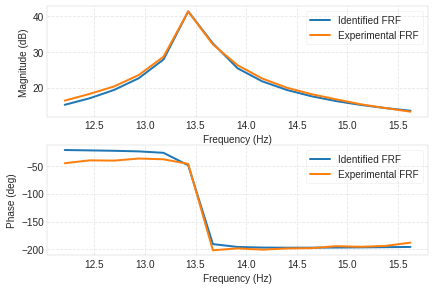

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


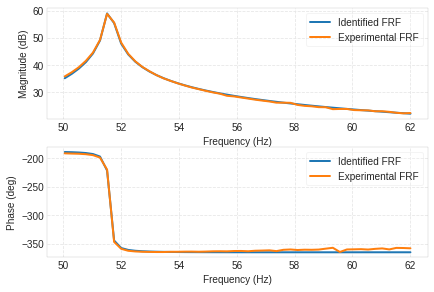

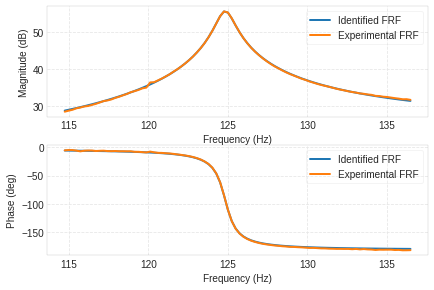

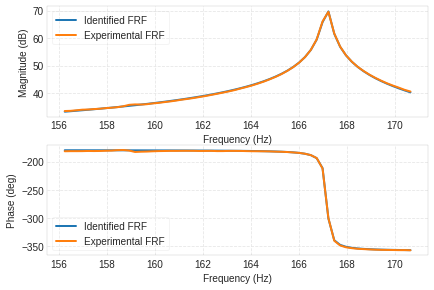

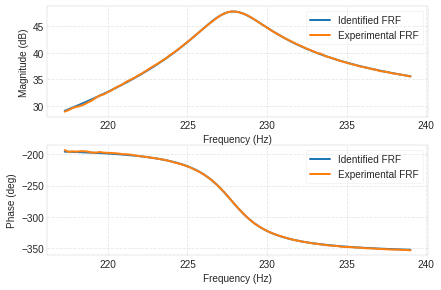

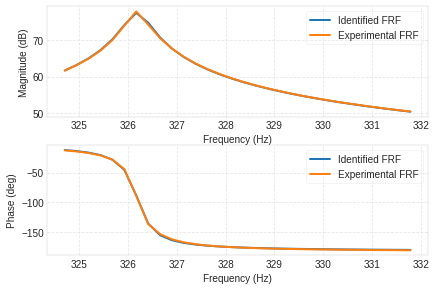

In [121]:
%matplotlib inline
vt.sdof_cf(f,h15,50,65)
vt.sdof_cf(f,h15,205,255)
vt.sdof_cf(f,h15,470,560)
vt.sdof_cf(f,h15,640,700)
vt.sdof_cf(f,h15,890,980)
vt.sdof_cf(f,h15,1330,1360)
plt.show()

**Observations:**

- Curve fit looks fine.



#### Visually validating FRF at point 16:

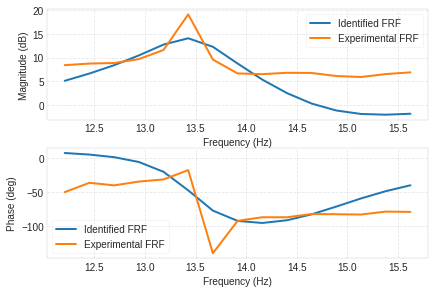

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


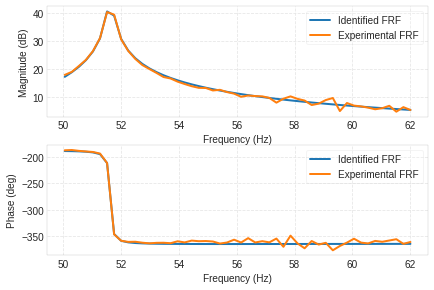

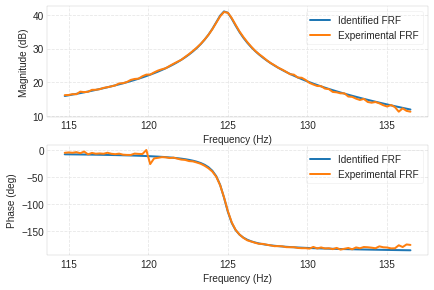

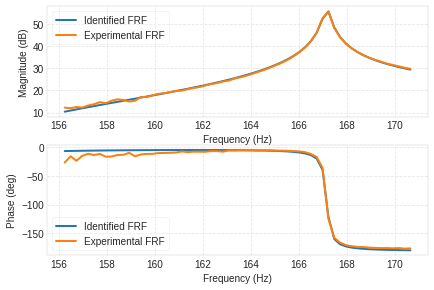

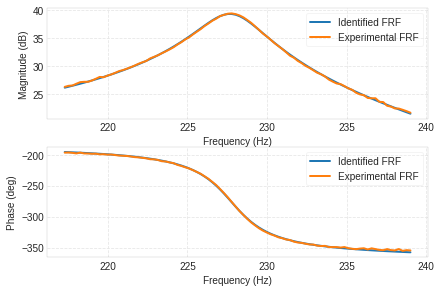

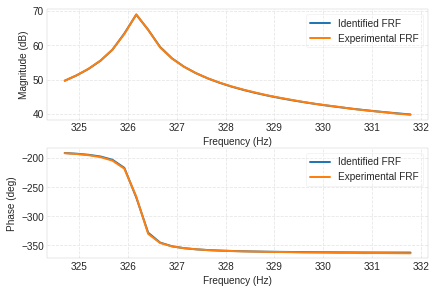

In [123]:
%matplotlib inline
vt.sdof_cf(f,h16,50,65)
vt.sdof_cf(f,h16,205,255)
vt.sdof_cf(f,h16,470,560)
vt.sdof_cf(f,h16,640,700)
vt.sdof_cf(f,h16,890,980)
vt.sdof_cf(f,h16,1330,1360)
plt.show()

**Observation:**
- Curve fit for mode 1 looks bad but still the bounds are not adjusted because there is no Mode 1 at point 16 as it would not move in torsion. So, it's a node. Ajusting it to fit well and using that value for other FRFs may not be reliable. Hence, no changes were made to adjust curve fit.



#### Visually validating FRF at point 17:

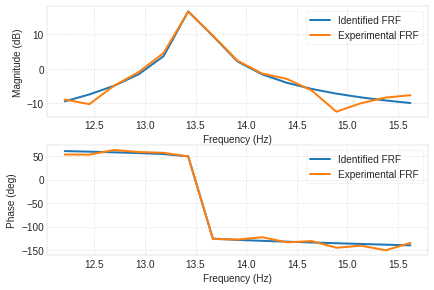

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


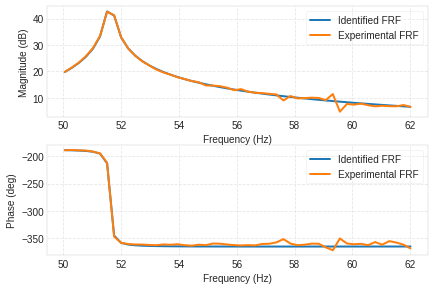

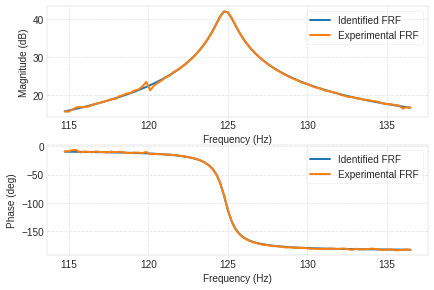

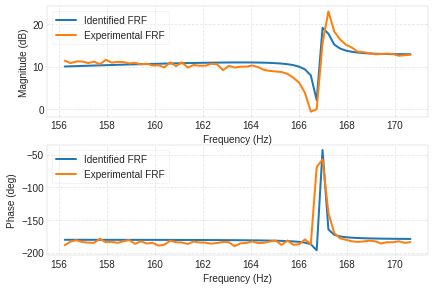

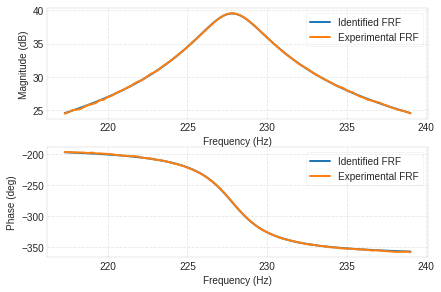

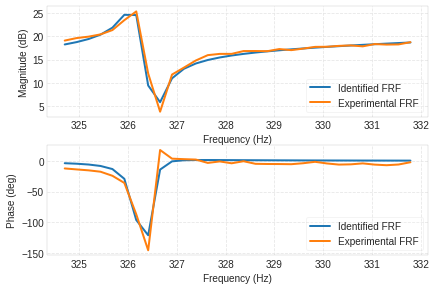

In [124]:
%matplotlib inline
vt.sdof_cf(f,h17,50,65)
vt.sdof_cf(f,h17,205,255)
vt.sdof_cf(f,h17,470,560)
vt.sdof_cf(f,h17,640,700)
vt.sdof_cf(f,h17,890,980)
vt.sdof_cf(f,h17,1330,1360)
plt.show()

**Observation:**
- Curve fit for mode 4 and 6 looks bad but still the bounds are not adjusted because there is no Mode 4 and Mode 6 at point 17 as it would not move in torsion. So, it's a node. Ajusting it to fit well and using that value for other FRFs may not be reliable. Hence, no changes were made to adjust curve fit.



#### Visually validating FRF at point 18:

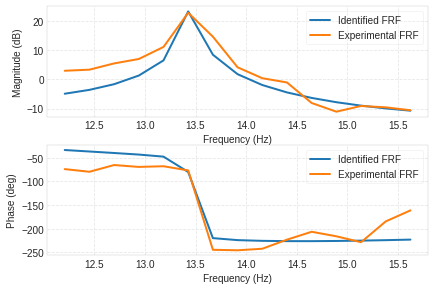

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


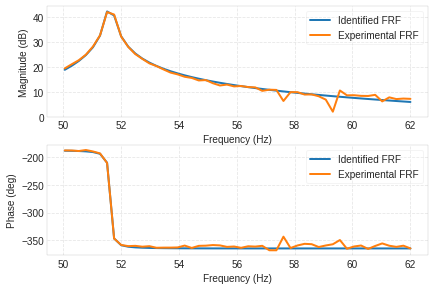

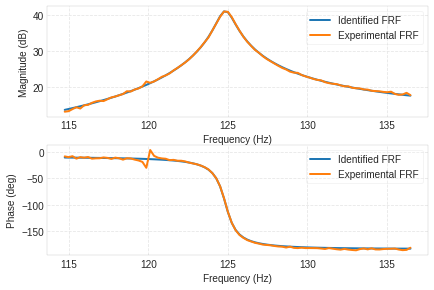

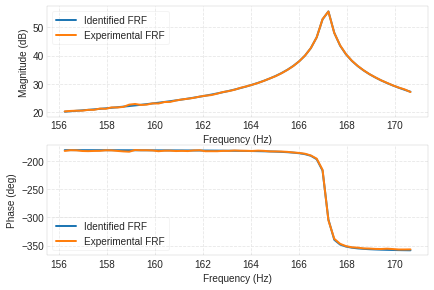

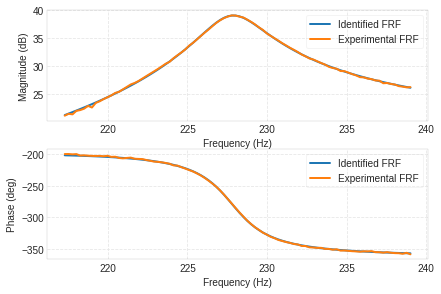

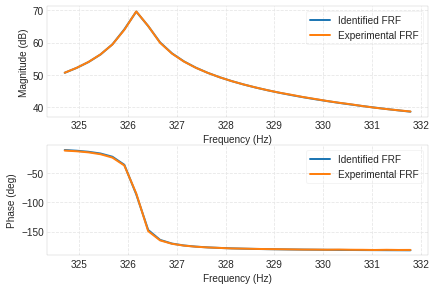

In [125]:
%matplotlib inline
vt.sdof_cf(f,h18,50,65)
vt.sdof_cf(f,h18,205,255)
vt.sdof_cf(f,h18,470,560)
vt.sdof_cf(f,h18,640,700)
vt.sdof_cf(f,h18,890,980)
vt.sdof_cf(f,h18,1330,1360)
plt.show()

**Observation:**
- Curve fit for mode 1 looks bad but still the bounds are not adjusted because there is no Mode 1 at point 18 as it would not move in first bending. So, it's a node. Ajusting it to fit well and using that value for other FRFs may not be reliable. Hence, no changes were made to adjust curve fit.



### Result obtained from MDOF_CF Curve fitting before corrections:

#### Natural Frequencies before correction:

In [186]:
Naturalfreq


(13.513592922165163,
 51.604273251933932,
 124.8398698660464,
 167.17723579950587,
 227.77341036394043,
 326.23424885500293)

#### Damping ratios before correction:

In [187]:
Damping

(0.0019655960141334071,
 0.0013533430499988129,
 0.0040876427711924622,
 0.00062339960942436098,
 0.0085864609141319253,
 0.00074951350217168004)

#### Mode shapes before correction:

In [188]:
Psi_1

array([[   390.134823276,   1366.194032079,   2758.767960332,   4315.189543259,   3929.319061154,  11560.800459018],
       [   388.799543996,   1417.578142842,   2864.548595788,     46.166728102,   4674.348736216,    469.961114479],
       [   390.301079663,   1399.340332269,   2668.802033737,  -4026.320930933,   4585.575731666, -10545.110217327],
       [   264.625736211,    128.883968158,  -1481.535101632,   4684.42632799 ,  -4840.849765858,   6526.996728772],
       [   248.010851716,    129.910499007,  -1471.840766532,    291.231048297,  -4199.869211483,    347.592229302],
       [   249.124209741,    115.477188486,  -1681.472674127,  -3727.624724573,  -4101.238789696,  -5126.39864228 ],
       [   156.179733997,   -627.535212874,  -1182.69771731 ,   4044.931860657,   1676.175969996,  -1616.179105312],
       [   145.998813821,   -599.619966806,  -1202.054140314,    256.015195851,   1775.310914897,    253.092723114],
       [   150.716528321,   -611.084712374,  -1328.946528692,  -

### MDOF Polynomial Curve fitting after correcting bounds:

In [189]:
TF= np.column_stack((h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12,h13,h14,h15,h16,h17,h18))
[Damping1,naturalfreq1,U1]=vt.mdof_cf(f,TF,50,65)
[Damping2,naturalfreq2,U2]=vt.mdof_cf(f,TF,205,255)
[Damping3,naturalfreq3,U3]=vt.mdof_cf(f,TF,470,560)
[Damping4,naturalfreq4,U4]=vt.mdof_cf(f,TF,640,700)
[Damping5,naturalfreq5,U5]=vt.mdof_cf(f,TF,890,980)
[Damping6,naturalfreq6,U6]=vt.mdof_cf(f,TF,1330,1360)
Damping = Damping1, Damping2, Damping3, Damping4, Damping5, Damping6
Naturalfreq = naturalfreq1, naturalfreq2, naturalfreq3, naturalfreq4, naturalfreq5, naturalfreq6
Psi_1 = np.array(U1)
Psi_2 = np.array(U2)
Psi_3 = np.array(U3)
Psi_4 = np.array(U4)
Psi_5 = np.array(U5)
Psi_6 = np.array(U6)
Psi_1=np.column_stack((Psi_1,Psi_2,Psi_3,Psi_4,Psi_5,Psi_6))
Psi_abs = np.abs(Psi_1)*np.real(np.sign(Psi_1))
Psi_1 = Psi_abs

## Using "Least Square Complex Frequency domain method" from OpenModal GUI



The following two paragraphs are directly pasted from the help part for the code lscf.py in OpenModal software:

The LSCF method is an frequency-domain Linear Least Squares estimator optimized  for modal parameter estimation. The choice of the most important algorithm characteristics is based on the results in [1] (Section 5.3.3.) and can be summarized as:- Formulation: the normal equations [1] (Eq. 5.26: [sum(Tk - Sk.H * Rk^-1 * Sk)]*ThetaA=D*ThetaA = 0)are constructed for the common denominator discrete-time model in the Z-domain. Consequently, by looping over the outputs and inputs, the submatrices Rk, Sk, and Tk are formulated through the use of the FFT algorithm as Toeplitz structured (n+1) square matrices. Using complex coefficients, the FRF data within the frequency band of interest (FRF-zoom) is projected in the Z-domain in the interval of [0, 2*pi] in order to improve numerical conditioning. (In the case that real coefficients are used, the data is projected in the interval of [0, pi].) The projecting on an interval that does not completely describe the unity circle, say [0, alpha*2*pi] where alpha is typically 0.9-0.95. Deliberately over-modeling is best applied to cope with discontinuities. This is justified by the use of a discrete time model in the Z-domain, which is much more robust for a high order of the transfer function polynomials.

Solver: the normal equations can be solved for the denominator coefficients ThetaA by computing the Least-Squares (LS) or mixed Total-Least-Squares (TLS) solution. The inverse of the square matrix D for the LS solution is computed by means of a pseudo inverse operation for reasons of numerical stability, while the mixed LS-TLS solution is computed using an SVD (Singular Value Decomposition).

![alt](img/LSCF)

The above curve fitting was done using OpenModal GUI. This whole thing is referred to as Stabilization diagram. The symbol '+' indicates that frequency is found and the yellow dot is an indication for damping.

The max order is give as thirty, which means 30 iterations. The number of iterations depends on the repeatability of the results iteration after iteration. Usually, we can stop at 3rd or 4th iteration after it becomes stable. If it continues then eventually things start to break down because the system starts to find more and more resonance that don't exist.

Apart from the actual FRF and the curve fitter in blue, we can also see response signal in green which is  called as Mode Indicator function. MIF goes through all of the FRFs, here we have 18 which is a very small test, many other tests have hundreds of those. So, here it goes through 18 FRFs and globally determine if we really have a mode at a location or not. Because at some of these measurements  there is no motion, those are called nodes on the structure. Hence, we cannot have just one measurement to determine that.

## Using another MDOF curve fitter "Least Square Complex Exponential Curve Fitter" 



**LSCE: **

This curve fitter can curve fit all the resonances at a time which is better because it takes into account the influence of one mode on the other. In this case, no complexity in the data set observed because every peak is well seperated. However, some FRFs are very difficult to determine what is happening and in that case a global curve fitter which curve fits multiple resonances at a time would be a better option to choose.

The Least-Squares Complex Exponential method (LSCE), is the extension of the Complex Exponential method (CE) to a global procedure. It is therefore a SIMO method, processing simultaneously several IRFs obtained by exciting a structure at one single point and measuring the responses at several locations. With such a procedure, a consistent set of global parameters (natural frequencies and damping factors) is obtained, thus overcoming the variations obtained in the results for those parameters when applying the CE method on different IRFs.



![alt](img/LSCE)

**Important Observations:**

'+' implies: found natural frequencies. If we look at the stability diagram, the system split to find two natural frequencies. Because of the mass loading the frequency response was shifting, after while the system may declare that we don't have one resonance but two of them. This is because the data set was not good.

The way to approach this is to do curve fitting differently that is not global like above but local as we already done before. Local means that each measurement is going to be curve fitted one by one.

In order to be sure about the results obtained from curve fitting, three different curve fitter were used to mix and match the results.

## Analysis Validation



The Validation process consist into 3 steps required to validate modal results to make sure the curve fitting process was done properly and real modes have been selected and that errors like mode duplication due to variable mass loading have been avoided:

- Animation


- AutoMAC


- CrossMAC

### Animation of the curve fit results:

#### Natural Frequencies, Damping and Mode shapes obtained: 

![alt](img/LS01) ![alt](img/LS02) ![alt](img/LS03) ![alt](img/LS04) ![alt](img/LS05) ![alt](img/LS06) 

### Results from curve fitting using Global curve fitters with mass loading issue :

In [196]:
NaturalfreqGlobalCF=Naturalfreq
NaturalfreqGlobalCF

(13.516125495327145,
 51.602555175851712,
 124.8398698660464,
 167.17677576486767,
 227.77341036394043,
 326.23386712013291)

In [197]:
DampingGlobalCF=Damping
DampingGlobalCF

(0.0017411648392746146,
 0.0012488031601881739,
 0.0040876427711924622,
 0.00062677328877069872,
 0.0085864609141319253,
 0.00074953837145838294)

In [198]:
#Psi_2=Psi_1[:15,:]
Psi_GlobalCF=Psi_1[:15,:]


## Results from Local curve fitting:

In [199]:
NaturalFreqlocal= 13.516, 51.607, 124.838, 167.175, 227.759, 326.254
NaturalFreqlocal

(13.516, 51.607, 124.838, 167.175, 227.759, 326.254)

In [200]:
Dampinglocal= 0.00164, 0.00119, 0.00413, 0.000614, 0.00875, 0.000729
Dampinglocal

(0.00164, 0.00119, 0.00413, 0.000614, 0.00875, 0.000729)

In [201]:
mat_contents=sio.loadmat('Modeshapedata/1stNaturalFreq15.mat')
U1 = mat_contents['U1']
mat_contents=sio.loadmat('Modeshapedata/2ndNaturalFreq15.mat')
U2 = mat_contents['U2']
mat_contents=sio.loadmat('Modeshapedata/3rdNaturalFreq15.mat')
U3 = mat_contents['U3']
mat_contents=sio.loadmat('Modeshapedata/4rthNaturalFreq15.mat')
U4 = mat_contents['U4']
mat_contents=sio.loadmat('Modeshapedata/5thNaturalFreq15.mat')
U5 = mat_contents['U5']
mat_contents=sio.loadmat('Modeshapedata/6thNaturalFreq15.mat')
U6 = mat_contents['U6']
Psi_1 = np.array(U1)
Psi_2 = np.array(U2)
Psi_3 = np.array(U3)
Psi_4 = np.array(U4)
Psi_5 = np.array(U5)
Psi_6 = np.array(U6)
Psi_1=np.column_stack((Psi_1,Psi_2,Psi_3,Psi_4,Psi_5,Psi_6))
Psi_abs = np.abs(Psi_1)*np.real(np.sign(Psi_1))
Psi_local = Psi_abs

## Analysis Validation:



**What is Correlation?**

- Correlation is the relationship between two or more things. Correlating is comparing two data sets and establishing a level of coherence or similarity between the two datasets.


- Correlation is a broad term often overloaded in Structural Dynamics. Customer will often refer to correlation when discussing:
        
     - Pretest Planning
     - Model Updating
     - Vector Comparison



### MAC:

The Modal Assurance Criterion (MAC) analysis is used to determine the similarity of two mode shapes:

* If the mode shapes are identical (i.e., all points move the same) the MAC will have a value of one or 100%. 


* If the mode shapes are very different, the MAC value will be close to zero.
 
*Note: A MAC analysis is only looking at the mode shape, it does not compare the frequency value.* 
 
#### MAC Equation:
 
The MAC value between two modes is essentially the normalized dot product of the complex modal vector at each common nodes (i.e., points), as shown in Equation.  It can also be thought of as the square of correlation between two modal vectors φr and φs. Equation below is the Modal Assurance Criterion equation for comparing two mode shapes:



![alt](img/image.png)


If a linear relationship exists (i.e., the vectors move the same way) between the two complex vectors, the MAC value will be near to one. If they are linearly independent, the MAC value will be small (near zero).
 
A complex vector simply includes both amplitude and phase, whereas a real vector is real part only. In Equation, it is also clear that the MAC is not sensitive to scaling, so if all mode shape components are multiplied with the same factor, the MAC will not be affected.

If an experimental modal analysis had 18 different nodes where measurements were made, the mode shape components at all 18 nodes are taken into account to calculate the MAC value, but more importance will be attributed to the higher amplitude node locations.
             


#### Resulting Eigen Vectors from Testing from LSCF:



Here, considered the case of an experimental modal analysis performed on a wing, suspended free on one end and clamped on the other. Frequency Response Function (FRF) data was acquired at 18 locations on the wing. The FRF data was analyzed and a mode set extracted. 

In [96]:
Psi_local

array([[   5.241707706,  -27.127615081,   52.843453543,  107.210143005,   71.139095015, -269.817342785],
       [   4.687209363,  -26.945738191,   52.183186313,   -7.83341953 ,   71.411534453,  -40.625538373],
       [   4.368421773,  -25.121917234,   51.597488464,  -99.159212806,   69.26683148 ,  238.962801192],
       [   3.519108382,   -7.307635452,  -36.871073212,  112.432870575,  -75.970925544, -209.599864678],
       [   3.99369394 ,   -8.550399951,  -37.014491536,   34.494279202,  -65.780768515,  -57.021770026],
       [   4.110844861,   -7.792721262,  -38.903453864,  -97.14023879 ,  -68.483622372,  185.356134448],
       [   3.912418166,   17.983583519,  -33.877855743,  101.225337752,   30.716200755,   95.968190423],
       [   3.359713741,   17.158904587,  -35.675183371,   37.881749912,   46.813407339,  -11.419977031],
       [   3.303682334,   17.92248139 ,  -34.000342956,  -88.24444254 ,   41.527236694, -103.954353298],
       [   2.277194422,   17.704562416,   27.531465665,

#### Resulting Eigen Vectors from Testing from Mdofcf:

In [97]:
Psi_mdofcf

array([[   391.396900441,   1350.863217315,   2758.767960332,   4323.937955293,   3929.319061154,  11564.045809709],
       [   389.888652884,   1401.557508972,   2864.548595788,     46.282694571,   4674.348736216,    470.770815997],
       [   391.594030375,   1383.27015504 ,   2668.802033737,  -4034.59177185 ,   4585.575731666, -10553.226626488],
       [   265.664014864,    127.27497387 ,  -1481.535101632,   4693.913382808,  -4840.849765858,   6522.998689593],
       [   248.205260784,    128.191541735,  -1471.840766532,    291.819931753,  -4199.869211483,    349.588226922],
       [   249.574897271,    114.011673509,  -1681.472674127,  -3734.976492183,  -4101.238789696,  -5132.730070617],
       [   156.177912428,   -620.450665591,  -1182.69771731 ,   4052.505435097,   1676.175969996,  -1616.018588163],
       [   145.851620097,   -592.821380785,  -1202.054140314,    256.454785799,   1775.310914897,    254.110020105],
       [   150.873730677,   -604.507564641,  -1328.946528692,  -

### Test-Test Comparison:

The important thing to remember while we do modal analysis is that, when we have some sort of a structure, then we need to know how many points along the structure to test. For instance, initially, the wing structure was tested taking a guess of number of points as nine to capture all of our mode shapes accurately, however, it was noticed that the modes seen essentially looks like rigid body motion at higher frequencies.

It is quite similar to aliasing, when we think about reading in frequencies where we did not sample high enough, but here its about not considering enough points on the structure. So, one way to check that enough points were used to accurately capture all versus different mode shapes by using something called the MAC matrix.

In [98]:
vt.mac(Psi_local,Psi_local)

array([[ 1.         ,  0.012878134,  0.024564134,  0.021402321,  0.04530025 ,  0.00297411 ],
       [ 0.012878134,  1.         ,  0.05357427 ,  0.003010583,  0.008900821,  0.01555768 ],
       [ 0.024564134,  0.05357427 ,  1.         ,  0.002131827,  0.162034548,  0.00183518 ],
       [ 0.021402321,  0.003010583,  0.002131827,  1.         ,  0.000965057,  0.020653144],
       [ 0.04530025 ,  0.008900821,  0.162034548,  0.000965057,  1.         ,  0.000017919],
       [ 0.00297411 ,  0.01555768 ,  0.00183518 ,  0.020653144,  0.000017919,  1.         ]])

In [99]:
vt.mac(Psi_mdofcf,Psi_mdofcf)

array([[ 1.         ,  0.269073894,  0.102481622,  0.007401745,  0.069646662,  0.003066059],
       [ 0.269073894,  1.         ,  0.304444271,  0.000951484,  0.123910692,  0.004512516],
       [ 0.102481622,  0.304444271,  1.         ,  0.000138272,  0.318991573,  0.000658865],
       [ 0.007401745,  0.000951484,  0.000138272,  1.         ,  0.005198078,  0.166818968],
       [ 0.069646662,  0.123910692,  0.318991573,  0.005198078,  1.         ,  0.001116943],
       [ 0.003066059,  0.004512516,  0.000658865,  0.166818968,  0.001116943,  1.         ]])

**AUTO MAC for Locally curve fitting is much better with low off-diagonal terms compared to global curve fit results**


**other reasons why Auto mac?**

Acquiring an additional 9 points leads to better results.  With 18 total points, the mode shapes look completely different. So, with less response points, the spatial aliasing error was created.

*Note: The term used of "not enough response points" is called "Spacial Aliasing".*

In the above case, this is a mode set compared to itself.  The mode set contains six different individual modes, so 36 different MAC values are being calculated. About half the values are redundant –e.g., the MAC value between mode 1 and 3 is the same as between mode 3 and 1.

The first mode shape at 13 Hz is identical to itself, hence a value of 1. Along the diagonal, every mode is identical to itself, 1 to 1 (13 Hz), 2 to 2 (51 Hz), 3 to 3 (121 Hz), etc.

If the off-diagonal MAC values are very low then that means the modes are not coherent to each other, they are completely separated, the accurate word being completely orthogonal(very different).  Ideally, each mode should be uniquely observed and have a different shape than the other modes.  This is the case for this mode set.  The highest off diagonal mode pair is mode 5 compared to mode 3 (and vice versa 3 to 5) with a MAC value of 16%. All the other off-diagonal mode pairs are below 16%. 

In experimental modal analysis, the data measured in the 9 point modal analysis is not "wrong". The FRF measurements at these nodes were no different in the 9 point modal versus the 18 point, since the physical structure being tested did not change.  There was simply not enough measurement points to determine the complete mode shape.  This is different than a Finite Element modal analysis were the number of nodes does determine the dynamic behavior.

**Reasons for higher off-diagonal terms in Auto MAC(For Test results):**
- Measurement problem
- Curve fit problem
- Spacial Aliasing

### Analysis Validation - Cross Mac

The CrossMac allows to compare two different shape tables obtained by two different curve fitting process. A good diagonal table will show that the two method agrees. Here we compare the Polynomial method with the Complex Exponential method and both aggress very well.

Again off diagonal values should be very low.

In [100]:
vt.mac(Psi_local,Psi_mdofcf)

array([[ 0.889809878,  0.055193656,  0.058956073,  0.014040708,  0.031198815,  0.002067656],
       [ 0.175763199,  0.929630918,  0.125022088,  0.000474301,  0.03448333 ,  0.008489398],
       [ 0.039119618,  0.178799012,  0.962237434,  0.000375055,  0.22862116 ,  0.001127759],
       [ 0.009763823,  0.00402185 ,  0.000184735,  0.949126268,  0.009918751,  0.084585362],
       [ 0.075319976,  0.058786428,  0.230012177,  0.000227881,  0.954436118,  0.000270986],
       [ 0.007821413,  0.010061935,  0.000838266,  0.072848187,  0.000199366,  0.926332305]])

### Beam Element model: 

A Matlab code was developed to solve different problems using 3D beam/rod/torsion element inside WFEM module by simply creating an input file.  The following were the resultant natural frequencies and mode shapes:

## Resulting eigen vectors from FE model:

In [107]:
mat_contents=sio.loadmat('FEmodaldata/WingBeamforMAC.mat')
K = (mat_contents['Kr'])
M = (mat_contents['Mr'])
Kbm = K.todense()
Mbm = M.todense()
omega, zeta, PsiBM = vt.sos_modal(Mbm, Kbm)
Psi_1 = PsiBM
mode1=Psi_1[:,0]
mode2=Psi_1[:,1]
mode3=Psi_1[:,3]
mode4=Psi_1[:,4]
mode5=Psi_1[:,5]
mode6=Psi_1[:,6]
Psi_2BM= np.column_stack((mode1, mode2, mode3, mode4, mode5, mode6))

### Brick Element model:

Similar to Beam code, an 8 noded Brick element was developed. The following are results obtained:

### Observations:

1. Beam model gave better results with lesser mesh compared to Brick model. Thereby saving computational time.


In [108]:
mat_contents=sio.loadmat('FEmodaldata/WingBrickmuchMorMeshedforMAC1.mat')
K = (mat_contents['Kr'])
M = (mat_contents['Mr'])
Kbr = K.todense()
Mbr = M.todense()
omega, zeta, PsiBR = vt.sos_modal(Mbr, Kbr)
Psi_1 = PsiBR
mode1=Psi_1[:,0]
mode2=Psi_1[:,1]
mode3=Psi_1[:,3]
mode4=Psi_1[:,4]
mode5=Psi_1[:,5]
mode6=Psi_1[:,6]
Psi_2BR= np.column_stack((mode1, mode2, mode3, mode4, mode5, mode6))




![alt](img/Brickmodelmode1.jpg) | ![alt](img/Brickmodelmode2.jpg) | ![alt](img/Brickmodelmode3.jpg) 

![alt](img/Brickmodelmode4.jpg) | ![alt](img/Brickmodelmode5.jpg) | ![alt](img/Brickmodelmode6.jpg)

### FE-FE comparison:

The below off-diagonal MAC values tell how bad the assumptions made were. We can observe that off-diagonal terms for the Brick model look better because of more mesh.


In [103]:
vt.mac(Psi_2BM,Psi_2BM)

array([[ 1.         ,  0.28416901 ,  0.172196744,  0.         ,  0.132407293,  0.         ],
       [ 0.28416901 ,  1.         ,  0.371274112,  0.         ,  0.235979076,  0.         ],
       [ 0.172196744,  0.371274112,  1.         ,  0.         ,  0.379744752,  0.         ],
       [ 0.         ,  0.         ,  0.         ,  1.         ,  0.         ,  0.240949039],
       [ 0.132407293,  0.235979076,  0.379744752,  0.         ,  1.         ,  0.         ],
       [ 0.         ,  0.         ,  0.         ,  0.240949039,  0.         ,  1.         ]])

In [104]:
vt.mac(Psi_2BR,Psi_2BR)

array([[ 1.         ,  0.122984639,  0.041348987,  0.         ,  0.026004283,  0.         ],
       [ 0.122984639,  1.         ,  0.157153609,  0.         ,  0.060581719,  0.         ],
       [ 0.041348987,  0.157153609,  1.         ,  0.         ,  0.168759104,  0.         ],
       [ 0.         ,  0.         ,  0.         ,  1.         ,  0.         ,  0.10115887 ],
       [ 0.026004283,  0.060581719,  0.168759104,  0.         ,  1.         ,  0.         ],
       [ 0.         ,  0.         ,  0.         ,  0.10115887 ,  0.         ,  1.         ]])

### Correlation FEM vs. Test

**Difference between FEM and Test:**
- Many more FEM DOF's than Test DOF's
     - More FEM DOF's are required for the model accuracy
        - FEM models are made of nodes and elements
     - Cost, complexity and mass loading limit the number of test DOF's
- Test DOF's may not be collocated with FEM DOF's
- Test and FEM may have different orientations
- FEM models do not typically incorporate damping
- Test modes typically are complex modes
- Mode Scaling and units can be different 
- A Mass and Stiffness matrix are calculated during the FEM solution
- A Mass, Stiffness and Damping matrix cannot be estimated from a Modal Test
- Boundary Conditions: Fixed or Free-Free?

### Geometry Alignment:

After Alignment is done Geometry are referring to the same coordinate system
    

### DOF Mapping:
    
A "DOF Map Table" will be calculated using the FEM results and Test shapes. Here each Test node will be mapped to a corresponding FEM node.

###### Extension of modes from Modal Analysis to All DOF of a Finite Element Model after applying Guyan reduction:

Only guyan reduction was applied on the full M and K from the created model using WFEM module(Matlab) to reduce the M and K matrix. SEREP could be applied to reduce the M and K matrices further, however, in this case it would not give accurate results as only 6 mode shapes are retained which would result in a very small 6x6 sized M and K matrices.

In [109]:
mat_contents=sio.loadmat('FEmodaldata/WingBeamforMAC.mat')
K = (mat_contents['Kr'])
M = (mat_contents['Mr'])
Kbm = K.todense()
Mbm = M.todense()
omega, zeta, PsiBM = vt.sos_modal(Mbm, Kbm)
measured = np.array([[1,6,11,16,21,26,31,36,41,46,51,56,61,66,71]])
omega=np.array([omega[0], omega[1], omega[3], omega[4], omega[5], omega[6]])
Psi_fullBM=vt.mode_expansion_from_model(Psi_local, omega, Mbm, Kbm, measured)


In [110]:
mat_contents=sio.loadmat('FEmodaldata/WingBrickmuchMorMeshedforMAC1.mat')
K = (mat_contents['Kr'])
M = (mat_contents['Mr'])
Kbr = K.todense()
Mbr = M.todense()
omega, zeta, PsiBR = vt.sos_modal(Mbr, Kbr)
measured = np.array([[350, 347, 344, 278, 275, 272, 206, 203, 200, 134, 131, 128, 62, 59, 56]])
omega=np.array([omega[0], omega[1], omega[3], omega[4], omega[5], omega[6]])
Psi_fullBR=vt.mode_expansion_from_model(Psi_local, omega, Mbr, Kbr, measured)


So, the alternative to reducing the matrices from the finite element model is to expand the measured mode shape vectors to estimate the data at unmeasured locations. Expanding the measured data invariably involves using the finite element model to fill in the missing data. The vibration testing module in python has the function mode_expansion_from_model which does the expansion process for us.


### FE-Test Comparison:

After collecting Frequency Response Functions (FRFs) on the wing, a MAC analysis was done between the first six experimental test modes and the first six finite element analysis modes. The results are shown below.


In [111]:
vt.mac(Psi_fullBM,Psi_2BM)

array([[ 0.902776121,  0.08397938 ,  0.133234332,  0.000280447,  0.069636931,  0.000567165],
       [ 0.157055975,  0.892874372,  0.1246398  ,  0.000251338,  0.095492976,  0.000255381],
       [ 0.029469884,  0.217923327,  0.896786436,  0.000113918,  0.154537904,  0.000015324],
       [ 0.009130519,  0.00258551 ,  0.001044216,  0.10351289 ,  0.00068626 ,  0.087508   ],
       [ 0.071166016,  0.067331544,  0.34484064 ,  0.000039387,  0.854315037,  0.000332692],
       [ 0.007015925,  0.009076935,  0.000333458,  0.899795777,  0.001109486,  0.124936721]])

In [112]:
vt.mac(Psi_fullBR,Psi_2BR)

array([[ 0.419687707,  0.000826393,  0.002039278,  0.000059746,  0.004514538,  0.000070361],
       [ 0.010436219,  0.383714861,  0.000050142,  0.000000193,  0.001243138,  0.000022064],
       [ 0.038379026,  0.000165336,  0.299634258,  0.000027009,  0.000093382,  0.000075664],
       [ 0.017322709,  0.001122434,  0.000278439,  0.492081088,  0.000266308,  0.014127599],
       [ 0.013926318,  0.069706433,  0.002956606,  0.000573113,  0.236123559,  0.000164655],
       [ 0.004917083,  0.007407191,  0.003720332,  0.005166634,  0.000011543,  0.428847769]])

Looking at the diagonal and off-diagonal of the MAC matrix:

Beam model observations: 

* Diagonal MAC values are not 100%, because the two sets of modes are not identical.
* Modes 4 and 6 are less than 25%, the reason being torsional modes.
* The highest off diagonal mode pair is mode 5 compared to mode 3 (and vice versa 3 to 5) with a MAC value of 34%. All the other off-diagonal mode pairs are below 16%.

Brick model:

* Diagonal MAC values are not even 50%, may be because the mode shape locations did not match well.
* Similar to the Beam model, torsional modes have very less diagonal MAC values. 
* The highest off diagonal mode pair is mode 1 compared to mode 3 (and vice versa 3 to 1) with a MAC value of 3%. All the other off-diagonal mode pairs are below 3%.

In this case, the MAC analysis indicates that there is room for improvement in the correlation of the test and FEA. This 
can be done by correcting the M and K from FE model using 'Baruch' method

### FE model Correction:

Baruch method of model correction is a Direct model updating Technique using modal data. This can be simply be performed using the model_correction_direct function in the vibration testing module in Python.


In [118]:
Mc.shape

(75, 75)

In [117]:
omega=np.array([13.54, 51.81, 125.19, 167.76, 228.05, 328.41])
Mc, Kc = vt.model_correction_direct(Psi_fullBM, omega, Mbm, Kbm, method='Baruch')
omega, zeta, PsiBM = vt.sos_modal(Mc, Kc)
Psi_2 = PsiBM
mode1=Psi_2[:,0]
mode2=Psi_2[:,1]
mode3=Psi_2[:,2]
mode4=Psi_2[:,3]
mode5=Psi_2[:,4]
mode6=Psi_2[:,5]
Psi_2BM= np.column_stack((mode1, mode2, mode3, mode4, mode5, mode6))

In [114]:
omega=np.array([13.54, 51.81, 125.19, 167.76, 228.05, 328.41])
Mc, Kc = vt.model_correction_direct(Psi_fullBR, omega, Mbr, Kbr, method='Baruch')
omega, zeta, PsiBR = vt.sos_modal(Mc, Kc)
Psi_2 = PsiBR
mode1=Psi_2[:,0]
mode2=Psi_2[:,1]
mode3=Psi_2[:,2]
mode4=Psi_2[:,3]
mode5=Psi_2[:,4]
mode6=Psi_2[:,5]
Psi_2BR= np.column_stack((mode1, mode2, mode3, mode4, mode5, mode6))

In [115]:
vt.mac(Psi_fullBM,Psi_2BM)

array([[ 0.881321121,  0.038974652,  0.026369503,  0.022319756,  0.043063273,  0.004626752],
       [ 0.151688823,  0.966339971,  0.083540347,  0.000101145,  0.00984486 ,  0.012454445],
       [ 0.026114408,  0.130064798,  0.985585275,  0.000779997,  0.146162695,  0.000792393],
       [ 0.000705308,  0.000182381,  0.000003272,  0.958222761,  0.000485955,  0.055843798],
       [ 0.016009234,  0.033694923,  0.135101087,  0.00022769 ,  0.999311401,  0.000000001],
       [ 0.000009955,  0.001125275,  0.002966466,  0.116284286,  0.000000452,  0.990680361]])

In [116]:
vt.mac(Psi_fullBR,Psi_2BR)

array([[ 0.698262238,  0.000359566,  0.001196876,  0.033783873,  0.000001657,  0.002985744],
       [ 0.08548994 ,  0.798983181,  0.011013081,  0.000197895,  0.016457018,  0.014427994],
       [ 0.01609378 ,  0.065317434,  0.895059712,  0.001135323,  0.055996187,  0.003718399],
       [ 0.025364975,  0.003495387,  0.004594898,  0.96107467 ,  0.000053346,  0.018941836],
       [ 0.013595906,  0.008849519,  0.049541316,  0.000901858,  0.978078484,  0.001089207],
       [ 0.004008585,  0.002180803,  0.030543414,  0.052915722,  0.000170555,  0.987921688]])

So, after updating the model the MAC matrix results improved drastically. When comparing the three observations made before correcting the model to after correcting:

* MAC values are still not 100%, but very close enough .
* MAC values of the torsional modes were improved to great extent.
* The highest off diagonal mode pair is mode 5 compared to mode 3 (and vice versa 3 to 5) with a MAC value of 34% before is now 13.5%. All the other off-diagonal mode pairs are below 16%. Thats for the Beam model. However, for the Brick off-diagonal terms increased.


### Uses:

A Modal Assurance Criterion (or MAC) analysis can be used in several different ways:

- Test-Test comparison – A MAC analysis can flag potential issues with the modal analysis results. Usually MAC will identify modes and areas that could benefit from acquiring more data points on the structure.


- FEA-FEA comparison – Several assumptions can be made in the creation of a FEA analysis: Young’s Modulus, boundary conditions, and mass density values to name a few. A MAC analysis can determine the degree to which these assumptions affect the resulting mode shapes.


- FEA-Test comparison – A MAC can be used to compare modes from an experimental modal analysis test to a Finite Element Analysis (FEA). It will indicate if the same mode shapes are found in both the test and FEA analysis.



### Conclusion:

A Modal Assurance Criterion (or MAC) analysis can be used for FEA-Test, FEA-FEA and Test-Test comparisons of modes. By analyzing a MAC matrix, an engineer can improve the quality of an experimental modal test, verify finite element models, and update FEA models with test data.